In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
# модули библиотеки PyTorch
import torch
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.nn import functional as F
import tensorflow as tf
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import f1_score
from pathlib import Path
from PIL import Image
import os
from torchsummary import summary
import datetime
from torchmetrics import JaccardIndex
import torch.optim as optim
import statistics

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cpu


Формируем pandas таблицу с путями к файлам изображений и соответствующим им маскам

In [3]:
alls_images = os.listdir('/house/train/images')
alls_images_train = []
for i in range(len(alls_images)):
    alls_images_train.append(Path('/house/train/images/'+alls_images[i]))

alls_masks = os.listdir('/house/train/masks')
alls_masks_new = []
for i in range(len(alls_images)):
    for j in range(len(alls_masks)):
        if alls_images[i][0:3] == alls_masks[j][0:3]:
            alls_masks_new.append(alls_masks[j])

alls_masks_train = []
for i in range(len(alls_masks_new)):
    alls_masks_train.append(Path('/house/train/masks/'+alls_masks_new[i]))
    
torch.manual_seed(17)
X_train, X_val, y_train, y_val = train_test_split(alls_images_train, alls_masks_train, train_size=6/7)
import torch

df_train = pd.DataFrame(list(zip(X_train, y_train)), columns = ['images', 'masks'])
df_val = pd.DataFrame(list(zip(X_val, y_val)), columns = ['images', 'masks'])


Прописываем класс Dataset. 30 изображений для тренировочной выборки, 5 для валидационной и 9 для тестовой

In [4]:
class Dataset_new():
    
    def __init__(self, image_dir):
        self.image_dir = image_dir
        
        
        
    def __len__(self):
        return len(self.image_dir)
    
    def __getitem__(self, index):
        image_fn = self.image_dir['images'][index]
        image_fp = os.path.join(image_fn)
        image = Image.open(image_fp)
        transform_img_tensor = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        transform_mask_tensor = transforms.Compose([
                transforms.ToTensor()
                ])
    
        image = transform_img_tensor(image)
        mask_fn = self.image_dir['masks'][index]
        mask_fp = os.path.join(mask_fn)
        mask = Image.open(mask_fp).convert("L")
        mask = transform_mask_tensor(mask)
        if image.shape[1]>image.shape[2]:
            image = transforms.Resize((256, round(256*image.shape[2]/image.shape[1])), Image.NEAREST)(image)
            mask = transforms.Resize((256, round(256*mask.shape[2]/mask.shape[1])), Image.NEAREST)(mask)
            image = F.pad(image, ((256 - image.shape[2])//2, round((256 - image.shape[2])/2+0.01)))
            mask = F.pad(mask, ((256 - mask.shape[2])//2, round((256 - mask.shape[2])/2+0.01)))
        elif image.shape[1]<image.shape[2]:
            image = transforms.Resize((round(256*image.shape[1]/image.shape[2]), 256), Image.NEAREST)(image)
            mask = transforms.Resize((round(256*image.shape[1]/image.shape[2]), 256), Image.NEAREST)(mask)
            image = F.pad(image, (0, 0, (256 - image.shape[1])//2, round((256 - image.shape[1])/2+0.01)))
            mask = F.pad(mask, (0, 0, (256 - mask.shape[1])//2, round((256 - mask.shape[1])/2+0.01)))
        else:
            image = transforms.Resize((256, 256), Image.NEAREST)(image)
            mask = transforms.Resize((256, 256), Image.NEAREST)(mask)
        '''
        x = np.random.randint(0, 2)
        y = np.random.randint(0, 2)
        image = self.__crop__(image, y, x)
        mask = self.__crop__(mask, y, x)
        
        z = np.random.randint(0, 2)
        if z == 0:
            image = transforms.functional.hflip(image)
            mask = transforms.functional.hflip(mask)
        #elif z == 1:
            #image = transforms.functional.vflip(image)
            #mask = transforms.functional.vflip(mask)
        #elif z == 2:
            #image = transforms.functional.vflip(image)
            #mask = transforms.functional.vflip(mask)
            #image = transforms.functional.hflip(image)
            #mask = transforms.functional.hflip(mask)
        t = np.random.randint(0, 2)
        if t == 0:
            image = transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))(image)

        '''
        return image, mask
    


In [5]:
dataset = Dataset_new(df_train)
print(len(dataset))
data_loader = DataLoader(dataset, batch_size=15)
print(len(dataset), len(data_loader))

X, Y = iter(data_loader).next()
print(X.shape, Y.shape)

30
30 2


C:\anaconda3\lib\site-packages\torchvision\transforms\transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


torch.Size([15, 3, 256, 256]) torch.Size([15, 1, 256, 256])


Базовая модель UNet

In [12]:
class UNet(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.Sigmoid = nn.Sigmoid()
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=32)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=32, out_channels=64)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)
        self.middle = self.conv_block(in_channels=256, out_channels=512)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=128, out_channels=64)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=64, out_channels=32)
        self.output = nn.Conv2d(in_channels=32, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_31_out_dr = self.dropout(contracting_31_out)
        contracting_32_out = self.contracting_32(contracting_31_out_dr) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_41_out_dr = self.dropout(contracting_41_out)
        contracting_42_out = self.contracting_42(contracting_41_out_dr) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.Sigmoid(self.output(expansive_42_out)) # [-1, num_classes, 256, 256]
        return output_out

Модель UNet с Res-блоками и механизмом внимания

In [19]:
class UNet(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.Relu = nn.ReLU()
        self.Sigmoid = nn.Sigmoid()
        self.Softmax = nn.Softmax2d()
        self.Upsample = torch.nn.Upsample(scale_factor=2)
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=32)
        self.contracting_11_res = self.shortcut_conv_block(in_channels=3, out_channels=32)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=32, out_channels=64)
        self.contracting_21_res = self.shortcut_conv_block(in_channels=32, out_channels=64)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_31_res = self.shortcut_conv_block(in_channels=64, out_channels=128)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_41_res = self.shortcut_conv_block(in_channels=128, out_channels=256)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)
        self.middle = self.conv_block(in_channels=256, out_channels=512)
        self.middle_res = self.shortcut_conv_block(in_channels=256, out_channels=512)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.phi_g_11 = self.shortcut_conv_block(in_channels=512, out_channels=256)
        self.theta_11 = self.theta_conv_block(in_channels=256, out_channels=256)
        self.psi_11 = nn.Conv2d(in_channels=256, out_channels=1, kernel_size=1, stride=1)
        self.result_att_11 = self.shortcut_conv_block(in_channels=256, out_channels=256)
        self.expansive_12 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_12_res = self.shortcut_conv_block(in_channels=512, out_channels=256)
        
        self.expansive_21 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.phi_g_21 = self.shortcut_conv_block(in_channels=256, out_channels=128)
        self.theta_21 = self.theta_conv_block(in_channels=128, out_channels=128)
        self.psi_21 = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=1, stride=1)
        self.result_att_21 = self.shortcut_conv_block(in_channels=128, out_channels=128)
    
        self.expansive_22 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_22_res = self.shortcut_conv_block(in_channels=256, out_channels=128)
        
        self.expansive_31 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.phi_g_31 = self.shortcut_conv_block(in_channels=128, out_channels=64)
        self.theta_31 = self.theta_conv_block(in_channels=64, out_channels=64)
        self.psi_31 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1)
        self.result_att_31 = self.shortcut_conv_block(in_channels=64, out_channels=64)
        self.expansive_32 = self.conv_block(in_channels=128, out_channels=64)
        self.expansive_32_res = self.shortcut_conv_block(in_channels=128, out_channels=64)
        
        self.expansive_41 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.phi_g_41 = self.shortcut_conv_block(in_channels=64, out_channels=32)
        self.theta_41 = self.theta_conv_block(in_channels=32, out_channels=32)
        self.psi_41 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=1, stride=1)
        self.result_att_41 = self.shortcut_conv_block(in_channels=32, out_channels=32)
        self.expansive_42 = self.conv_block(in_channels=64, out_channels=32)
        self.expansive_42_res = self.shortcut_conv_block(in_channels=64, out_channels=32)
        self.output = nn.Conv2d(in_channels=32, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
    
    def shortcut_conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1),
                           nn.BatchNorm2d(num_features=out_channels))    
        return block
    def theta_conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=2, stride=2),
                           nn.BatchNorm2d(num_features=out_channels))    
        return block
    
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_11_out_res = self.Relu(torch.add(self.contracting_11_res(X), contracting_11_out))
        contracting_12_out = self.contracting_12(contracting_11_out_res) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_21_out_res = self.Relu(torch.add(self.contracting_21_res(contracting_12_out), contracting_21_out))
        contracting_22_out = self.contracting_22(contracting_21_out_res) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_31_out_res = self.Relu(torch.add(self.contracting_31_res(contracting_22_out), contracting_31_out))
        #contracting_31_out_dr = self.dropout(contracting_31_out)
        contracting_32_out = self.contracting_32(contracting_31_out_res) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_41_out_res = self.Relu(torch.add(self.contracting_41_res(contracting_32_out), contracting_41_out))
        #contracting_41_out_dr = self.dropout(contracting_41_out)
        contracting_42_out = self.contracting_42(contracting_41_out_res) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        middle_out_res = self.Relu(torch.add(self.middle_res(contracting_42_out), middle_out))
        
        expansive_11_out = self.Relu(self.expansive_11(middle_out_res))
        expansive_11_psi = self.Upsample(self.Softmax(self.psi_11(self.Relu(torch.add(self.phi_g_11(middle_out_res), self.theta_11(contracting_41_out_res)))))).repeat(1, 256, 1, 1)
        expansive_11_att = self.Relu(self.result_att_11(torch.mul(expansive_11_psi, contracting_41_out_res)))
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, expansive_11_att), dim=1))
        expansive_12_out_res = self.Relu(torch.add(self.expansive_12_res(torch.cat((expansive_11_out, expansive_11_att), dim=1)), expansive_12_out))
        
        expansive_21_out = self.Relu(self.expansive_21(expansive_12_out_res))
        expansive_21_psi = self.Upsample(self.Softmax(self.psi_21(self.Relu(torch.add(self.phi_g_21(expansive_12_out_res), self.theta_21(contracting_31_out_res)))))).repeat(1, 128, 1, 1)
        expansive_21_att = self.Relu(self.result_att_21(torch.mul(expansive_21_psi, contracting_31_out_res)))
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, expansive_21_att), dim=1)) 
        expansive_22_out_res = self.Relu(torch.add(self.expansive_22_res(torch.cat((expansive_21_out, expansive_21_att), dim=1)), expansive_22_out))
        
        expansive_31_out = self.Relu(self.expansive_31(expansive_22_out_res))
        expansive_31_psi = self.Upsample(self.Softmax(self.psi_31(self.Relu(torch.add(self.phi_g_31(expansive_22_out_res), self.theta_31(contracting_21_out_res)))))).repeat(1, 64, 1, 1)
        expansive_31_att = self.Relu(self.result_att_31(torch.mul(expansive_31_psi, contracting_21_out_res)))
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, expansive_31_att), dim=1)) 
        expansive_32_out_res = self.Relu(torch.add(self.expansive_32_res(torch.cat((expansive_31_out, expansive_31_att), dim=1)), expansive_32_out))
        
        expansive_41_out = self.Relu(self.expansive_41(expansive_32_out_res))
        expansive_41_psi = self.Upsample(self.Softmax(self.psi_41(self.Relu(torch.add(self.phi_g_41(expansive_32_out_res), self.theta_41(contracting_11_out_res)))))).repeat(1, 32, 1, 1)
        expansive_41_att = self.Relu(self.result_att_41(torch.mul(expansive_41_psi, contracting_11_out_res)))
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, expansive_41_att), dim=1)) 
        expansive_42_out_res = self.Relu(torch.add(self.expansive_42_res(torch.cat((expansive_41_out, expansive_41_att), dim=1)), expansive_42_out))
        
        output_out = self.Sigmoid(self.output(expansive_42_out_res))
        return output_out

In [7]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
LR = 0.01
model = UNet(num_classes=1)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.BCELoss()
epochs = 200
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 10)

In [9]:
from torchsummary import summary
summary(model, (3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32, 256, 256]        --
|    └─Conv2d: 2-1                       [-1, 32, 256, 256]        896
|    └─ReLU: 2-2                         [-1, 32, 256, 256]        --
|    └─BatchNorm2d: 2-3                  [-1, 32, 256, 256]        64
|    └─Conv2d: 2-4                       [-1, 32, 256, 256]        9,248
|    └─BatchNorm2d: 2-5                  [-1, 32, 256, 256]        64
├─Sequential: 1-2                        [-1, 32, 256, 256]        --
|    └─Conv2d: 2-6                       [-1, 32, 256, 256]        128
|    └─BatchNorm2d: 2-7                  [-1, 32, 256, 256]        64
├─ReLU: 1-3                              [-1, 32, 256, 256]        --
├─MaxPool2d: 1-4                         [-1, 32, 128, 128]        --
├─Sequential: 1-5                        [-1, 64, 128, 128]        --
|    └─Conv2d: 2-8                       [-1, 64, 128, 128]        18,496
|    └

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32, 256, 256]        --
|    └─Conv2d: 2-1                       [-1, 32, 256, 256]        896
|    └─ReLU: 2-2                         [-1, 32, 256, 256]        --
|    └─BatchNorm2d: 2-3                  [-1, 32, 256, 256]        64
|    └─Conv2d: 2-4                       [-1, 32, 256, 256]        9,248
|    └─BatchNorm2d: 2-5                  [-1, 32, 256, 256]        64
├─Sequential: 1-2                        [-1, 32, 256, 256]        --
|    └─Conv2d: 2-6                       [-1, 32, 256, 256]        128
|    └─BatchNorm2d: 2-7                  [-1, 32, 256, 256]        64
├─ReLU: 1-3                              [-1, 32, 256, 256]        --
├─MaxPool2d: 1-4                         [-1, 32, 128, 128]        --
├─Sequential: 1-5                        [-1, 64, 128, 128]        --
|    └─Conv2d: 2-8                       [-1, 64, 128, 128]        18,496
|    └

In [8]:
jaccard = JaccardIndex(num_classes = 2).to(device)

In [9]:
dataset_val = Dataset_new(df_val)
data_loader_val = DataLoader(dataset_val, batch_size=5)
X, Y = iter(data_loader_val).next()
print(X.shape, Y.shape)

torch.Size([5, 3, 256, 256]) torch.Size([5, 1, 256, 256])


Первый эксперимент: базовая модель Unet

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.6611, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5799, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 0	 \Training Loss: 0.6204608976840973	     Validation Loss:39.16290283203125	 \ LR:0.01	 \ IOU_train:0.521441638469696	     IOU_val:0.3041854798793793


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.4889, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5423, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1	 \Training Loss: 0.5156178623437881	     Validation Loss:62.048606872558594	 \ LR:0.01	 \ IOU_train:0.6182769536972046	     IOU_val:0.19078826904296875


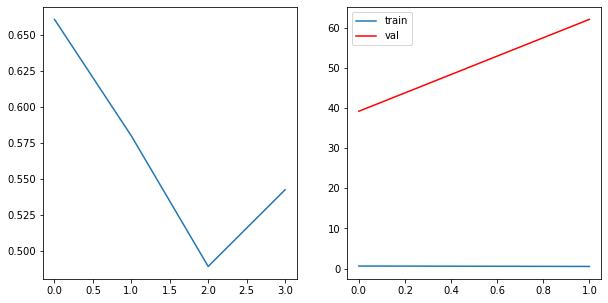

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.4050, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4394, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2	 \Training Loss: 0.4222121238708496	     Validation Loss:62.264404296875	 \ LR:0.01	 \ IOU_train:0.6780025959014893	     IOU_val:0.18867798149585724


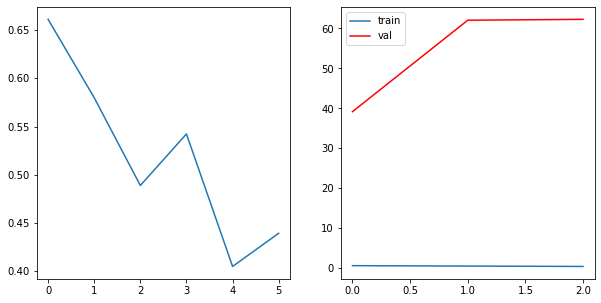

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.3698, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3889, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3	 \Training Loss: 0.3793180137872696	     Validation Loss:62.264404296875	 \ LR:0.01	 \ IOU_train:0.7200089693069458	     IOU_val:0.18867798149585724


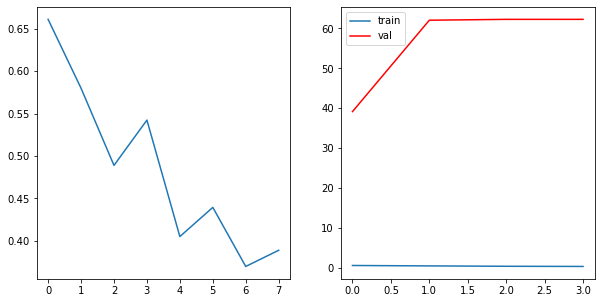

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.3330, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3152, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4	 \Training Loss: 0.3240598291158676	     Validation Loss:62.263031005859375	 \ LR:0.01	 \ IOU_train:0.7643587589263916	     IOU_val:0.18867798149585724


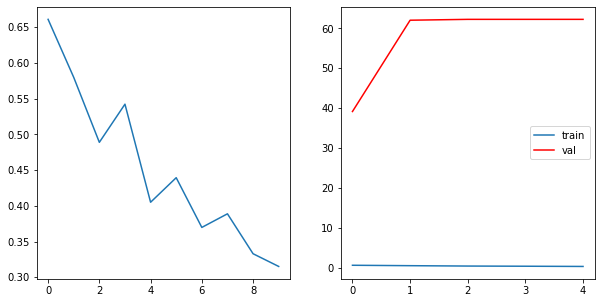

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.2995, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2785, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5	 \Training Loss: 0.2890188694000244	     Validation Loss:62.235939025878906	 \ LR:0.01	 \ IOU_train:0.7765361070632935	     IOU_val:0.1887052208185196


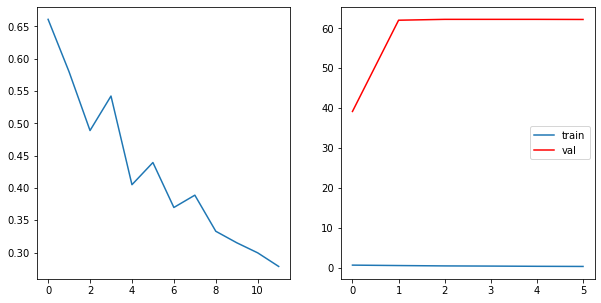

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.2388, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2413, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6	 \Training Loss: 0.24002452194690704	     Validation Loss:60.97736740112305	 \ LR:0.01	 \ IOU_train:0.8096263408660889	     IOU_val:0.1941002905368805


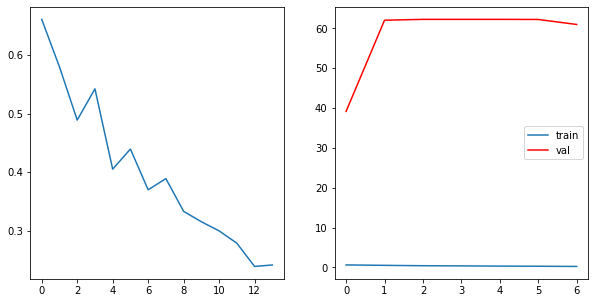

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.2099, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2076, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7	 \Training Loss: 0.20878373086452484	     Validation Loss:59.304718017578125	 \ LR:0.01	 \ IOU_train:0.8220152258872986	     IOU_val:0.20514856278896332


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.1962, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1788, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8	 \Training Loss: 0.1875419095158577	     Validation Loss:58.377777099609375	 \ LR:0.01	 \ IOU_train:0.8339959383010864	     IOU_val:0.20476557314395905


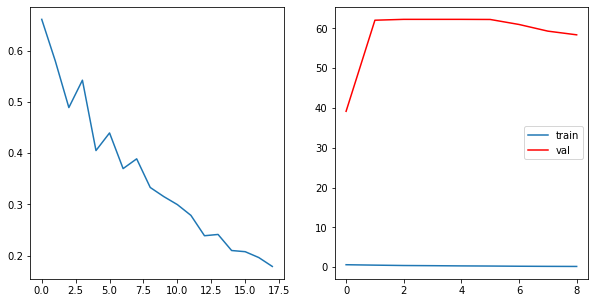

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.1675, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1579, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9	 \Training Loss: 0.16269207745790482	     Validation Loss:51.3476448059082	 \ LR:0.01	 \ IOU_train:0.8545817136764526	     IOU_val:0.24348551034927368


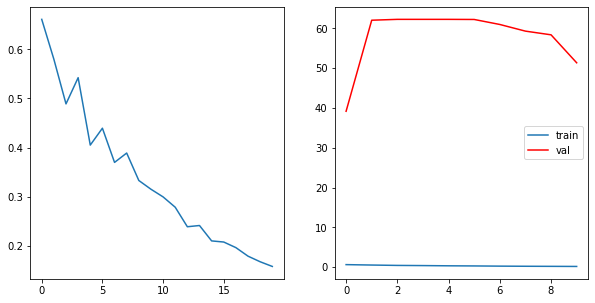

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.1494, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1381, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10	 \Training Loss: 0.14373980462551117	     Validation Loss:38.183528900146484	 \ LR:0.01	 \ IOU_train:0.8720650672912598	     IOU_val:0.2855205535888672


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.1497, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1128, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11	 \Training Loss: 0.1312291957437992	     Validation Loss:17.408138275146484	 \ LR:0.01	 \ IOU_train:0.8808642029762268	     IOU_val:0.384986937046051


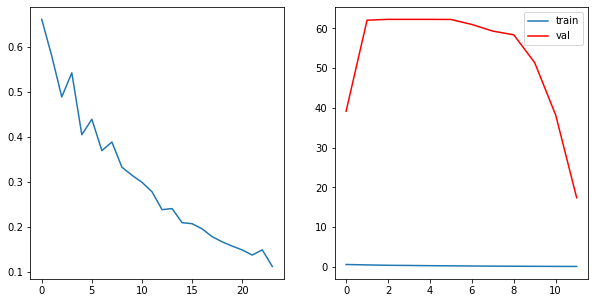

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.1288, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1021, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12	 \Training Loss: 0.11546196788549423	     Validation Loss:10.499862670898438	 \ LR:0.01	 \ IOU_train:0.8957289457321167	     IOU_val:0.468863844871521


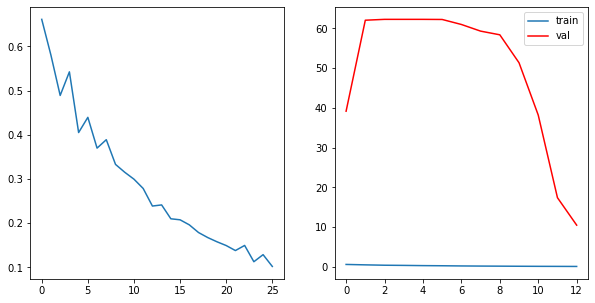

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.1016, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0959, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13	 \Training Loss: 0.09873972460627556	     Validation Loss:5.549497127532959	 \ LR:0.01	 \ IOU_train:0.9125133156776428	     IOU_val:0.5578450560569763


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0937, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0788, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14	 \Training Loss: 0.08623157814145088	     Validation Loss:2.6571381092071533	 \ LR:0.01	 \ IOU_train:0.9222633242607117	     IOU_val:0.5669647455215454


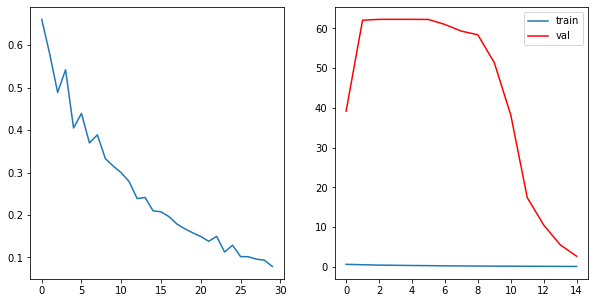

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0863, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0747, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15	 \Training Loss: 0.08049903064966202	     Validation Loss:1.8961584568023682	 \ LR:0.01	 \ IOU_train:0.9269462823867798	     IOU_val:0.5519125461578369


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0758, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0736, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16	 \Training Loss: 0.07466116920113564	     Validation Loss:2.1088287830352783	 \ LR:0.01	 \ IOU_train:0.9309655427932739	     IOU_val:0.5220323204994202


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0724, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0669, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17	 \Training Loss: 0.06961501017212868	     Validation Loss:1.892899751663208	 \ LR:0.01	 \ IOU_train:0.9358262419700623	     IOU_val:0.5118092894554138


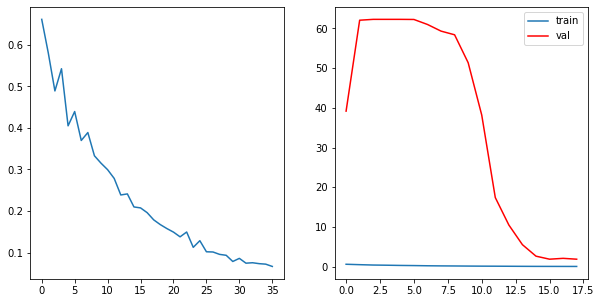

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0752, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0652, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18	 \Training Loss: 0.07018944248557091	     Validation Loss:1.9478381872177124	 \ LR:0.01	 \ IOU_train:0.9345850348472595	     IOU_val:0.4925912022590637


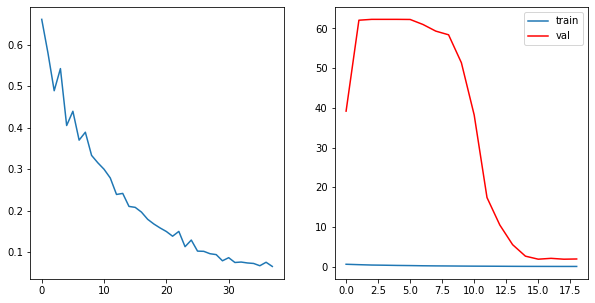

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0754, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0756, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19	 \Training Loss: 0.07554037868976593	     Validation Loss:2.03788685798645	 \ LR:0.01	 \ IOU_train:0.9300470948219299	     IOU_val:0.504304826259613


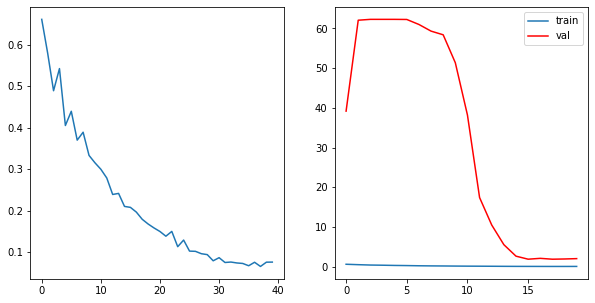

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0792, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0899, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20	 \Training Loss: 0.08455106616020203	     Validation Loss:2.0003092288970947	 \ LR:0.01	 \ IOU_train:0.9222766160964966	     IOU_val:0.48846644163131714


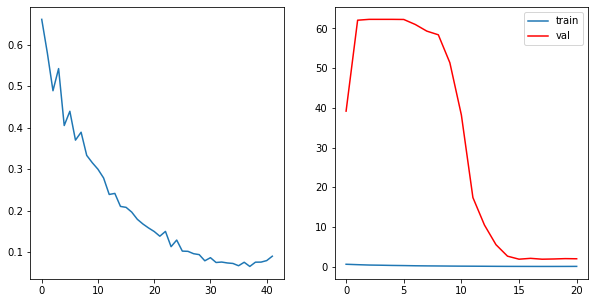

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0992, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0865, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21	 \Training Loss: 0.09286534041166306	     Validation Loss:2.0502493381500244	 \ LR:0.01	 \ IOU_train:0.9168329834938049	     IOU_val:0.41106897592544556


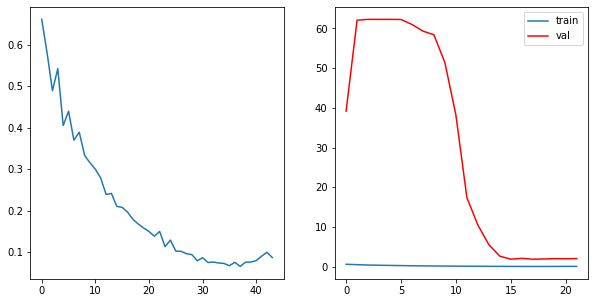

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0790, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1391, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22	 \Training Loss: 0.10906191542744637	     Validation Loss:1.9195711612701416	 \ LR:0.01	 \ IOU_train:0.9021661281585693	     IOU_val:0.46355152130126953


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.1035, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1061, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23	 \Training Loss: 0.10478908941149712	     Validation Loss:1.8474422693252563	 \ LR:0.01	 \ IOU_train:0.9100122451782227	     IOU_val:0.4948868155479431


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.1304, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0989, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24	 \Training Loss: 0.11464110016822815	     Validation Loss:2.077160358428955	 \ LR:0.01	 \ IOU_train:0.8984658718109131	     IOU_val:0.471149742603302


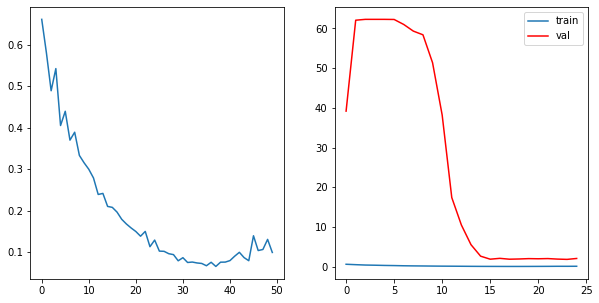

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.1292, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0883, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25	 \Training Loss: 0.10876531898975372	     Validation Loss:2.1480815410614014	 \ LR:0.01	 \ IOU_train:0.9028985500335693	     IOU_val:0.4038725197315216


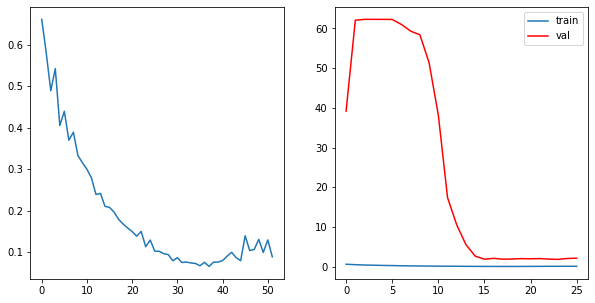

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0917, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0816, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26	 \Training Loss: 0.08666621148586273	     Validation Loss:2.0615756511688232	 \ LR:0.01	 \ IOU_train:0.9230263829231262	     IOU_val:0.41307947039604187


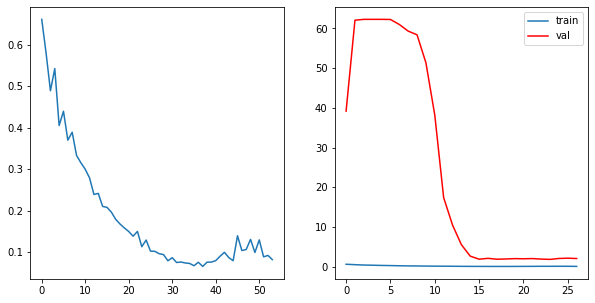

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0812, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0751, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27	 \Training Loss: 0.07815742865204811	     Validation Loss:2.1180880069732666	 \ LR:0.01	 \ IOU_train:0.9284846186637878	     IOU_val:0.41561251878738403


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0771, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0744, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28	 \Training Loss: 0.07575905323028564	     Validation Loss:2.0356411933898926	 \ LR:0.01	 \ IOU_train:0.9300599098205566	     IOU_val:0.40394914150238037


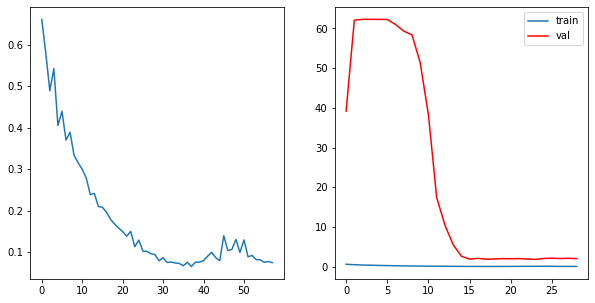

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0643, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0655, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29	 \Training Loss: 0.06491578370332718	     Validation Loss:1.9779555797576904	 \ LR:0.01	 \ IOU_train:0.9395564794540405	     IOU_val:0.413952499628067


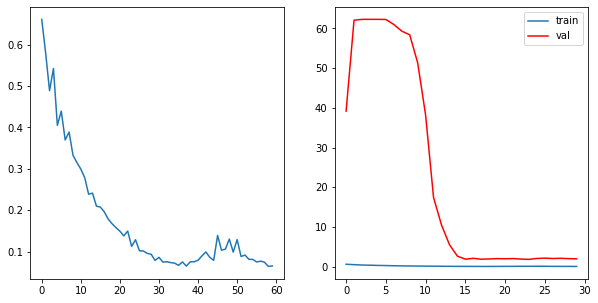

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0659, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0612, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30	 \Training Loss: 0.06353934668004513	     Validation Loss:1.8688348531723022	 \ LR:0.01	 \ IOU_train:0.9409269690513611	     IOU_val:0.4391801953315735


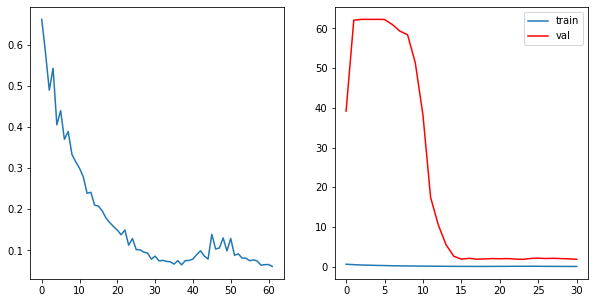

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0666, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0587, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31	 \Training Loss: 0.06266048736870289	     Validation Loss:1.774828553199768	 \ LR:0.01	 \ IOU_train:0.9428582787513733	     IOU_val:0.4912222623825073


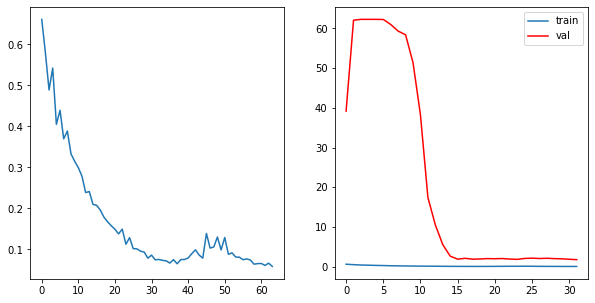

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0705, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0551, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32	 \Training Loss: 0.06280801445245743	     Validation Loss:1.7816250324249268	 \ LR:0.01	 \ IOU_train:0.9423782229423523	     IOU_val:0.4852253794670105


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0558, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0584, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33	 \Training Loss: 0.05709526129066944	     Validation Loss:1.8287134170532227	 \ LR:0.01	 \ IOU_train:0.947610080242157	     IOU_val:0.47644519805908203


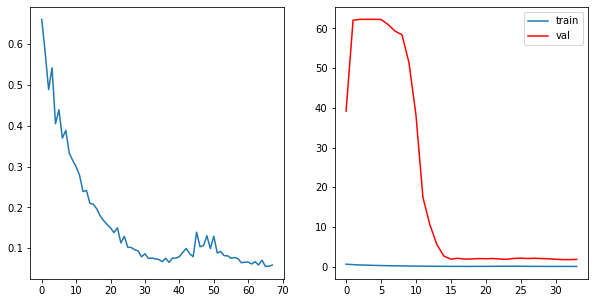

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0513, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0536, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34	 \Training Loss: 0.052471401169896126	     Validation Loss:1.8867847919464111	 \ LR:0.01	 \ IOU_train:0.9518080949783325	     IOU_val:0.4621926546096802


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0527, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0498, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35	 \Training Loss: 0.05122194439172745	     Validation Loss:1.857748031616211	 \ LR:0.01	 \ IOU_train:0.9518628120422363	     IOU_val:0.4397473931312561


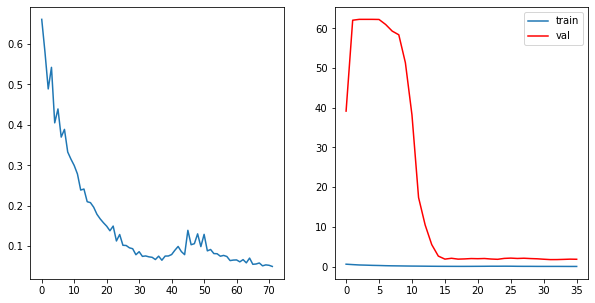

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0469, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0493, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36	 \Training Loss: 0.04810490272939205	     Validation Loss:1.9603798389434814	 \ LR:0.01	 \ IOU_train:0.9559887051582336	     IOU_val:0.431518018245697


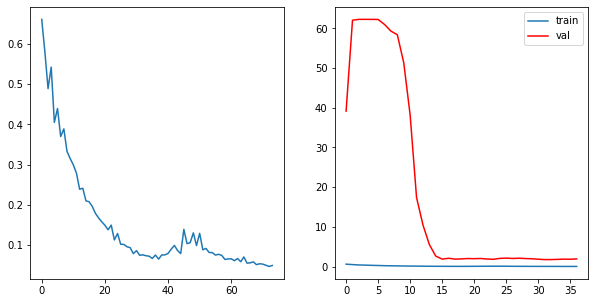

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0460, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0479, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37	 \Training Loss: 0.04691401310265064	     Validation Loss:2.0294528007507324	 \ LR:0.01	 \ IOU_train:0.9556503295898438	     IOU_val:0.42807072401046753


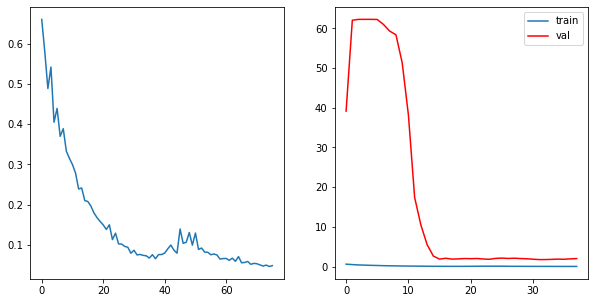

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0425, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0445, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38	 \Training Loss: 0.04352162033319473	     Validation Loss:1.9355030059814453	 \ LR:0.01	 \ IOU_train:0.9594073295593262	     IOU_val:0.4281198978424072


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0405, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0422, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39	 \Training Loss: 0.04134044982492924	     Validation Loss:1.7872302532196045	 \ LR:0.01	 \ IOU_train:0.9621989727020264	     IOU_val:0.4353518784046173


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0394, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0423, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40	 \Training Loss: 0.04086464084684849	     Validation Loss:1.7183414697647095	 \ LR:0.01	 \ IOU_train:0.9612406492233276	     IOU_val:0.44732898473739624


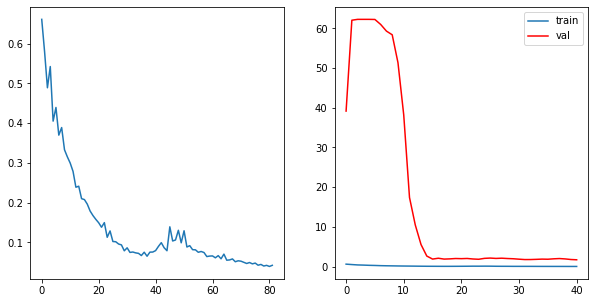

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0387, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0425, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41	 \Training Loss: 0.0405945535749197	     Validation Loss:1.699220061302185	 \ LR:0.01	 \ IOU_train:0.9623914957046509	     IOU_val:0.4510045051574707


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0386, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0413, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42	 \Training Loss: 0.03995038755238056	     Validation Loss:1.4727323055267334	 \ LR:0.01	 \ IOU_train:0.961884081363678	     IOU_val:0.4576123058795929


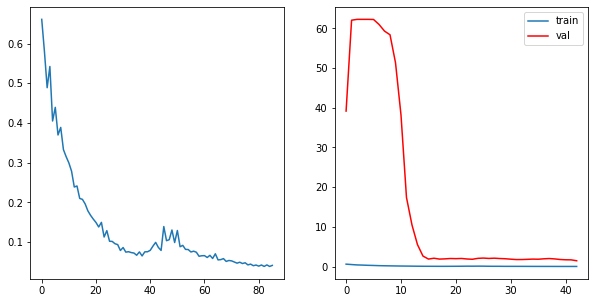

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0371, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0431, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43	 \Training Loss: 0.0400661863386631	     Validation Loss:1.2751672267913818	 \ LR:0.01	 \ IOU_train:0.9625266194343567	     IOU_val:0.49549973011016846


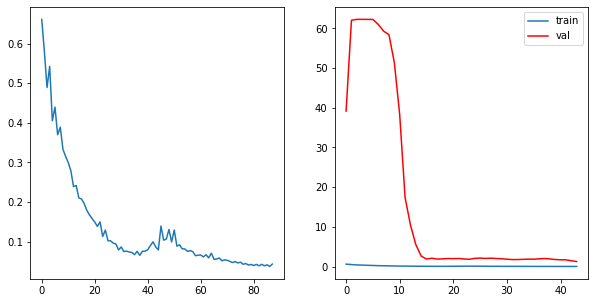

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0376, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0385, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44	 \Training Loss: 0.03802059777081013	     Validation Loss:1.258335828781128	 \ LR:0.01	 \ IOU_train:0.963892936706543	     IOU_val:0.4971679449081421


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0357, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0386, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45	 \Training Loss: 0.03716413304209709	     Validation Loss:1.1766659021377563	 \ LR:0.01	 \ IOU_train:0.9645789265632629	     IOU_val:0.49951812624931335


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0354, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0386, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46	 \Training Loss: 0.03696727380156517	     Validation Loss:0.950456440448761	 \ LR:0.01	 \ IOU_train:0.964694082736969	     IOU_val:0.5453728437423706


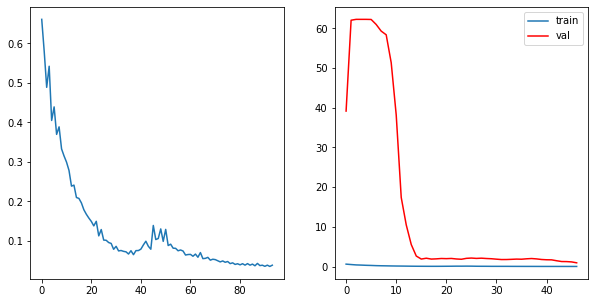

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0331, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0371, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47	 \Training Loss: 0.03512362763285637	     Validation Loss:0.6908499002456665	 \ LR:0.01	 \ IOU_train:0.9670717716217041	     IOU_val:0.6253258585929871


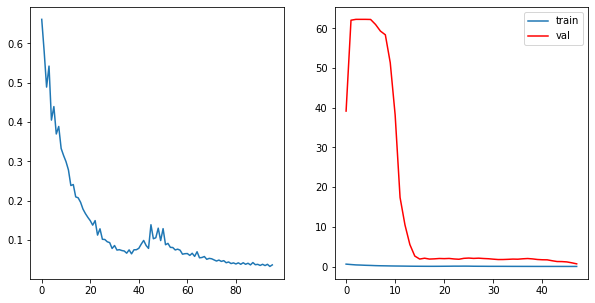

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0342, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0353, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48	 \Training Loss: 0.03478904254734516	     Validation Loss:0.5336462259292603	 \ LR:0.01	 \ IOU_train:0.9672896862030029	     IOU_val:0.6866313219070435


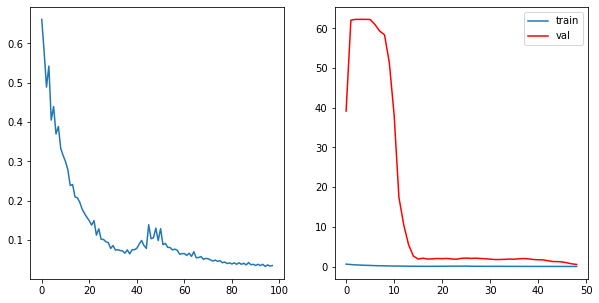

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0336, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0335, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49	 \Training Loss: 0.033543430268764496	     Validation Loss:0.4736924171447754	 \ LR:0.01	 \ IOU_train:0.9681285619735718	     IOU_val:0.7224191427230835


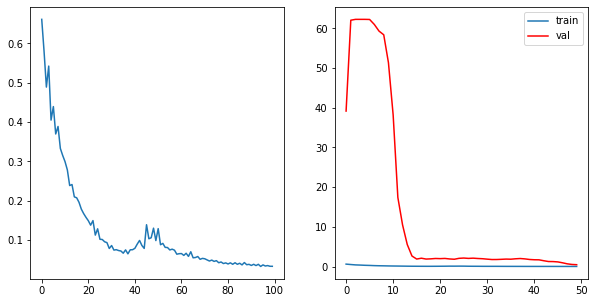

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0326, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0328, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50	 \Training Loss: 0.03268800489604473	     Validation Loss:0.38072195649147034	 \ LR:0.01	 \ IOU_train:0.9696046710014343	     IOU_val:0.7694841623306274


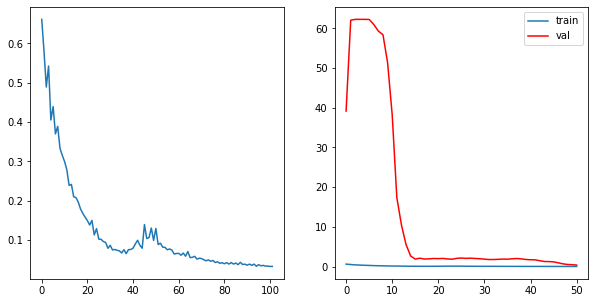

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0315, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0318, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 51	 \Training Loss: 0.031612856313586235	     Validation Loss:0.33933940529823303	 \ LR:0.01	 \ IOU_train:0.970150351524353	     IOU_val:0.7971405386924744


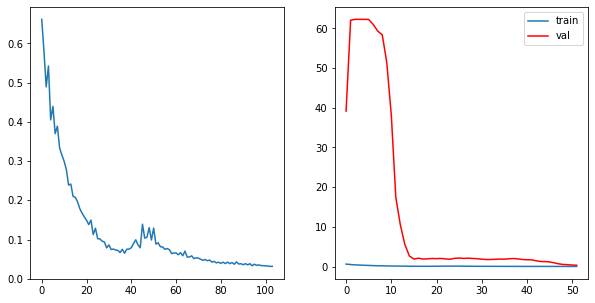

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0311, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0313, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 52	 \Training Loss: 0.031215296126902103	     Validation Loss:0.3289250433444977	 \ LR:0.01	 \ IOU_train:0.9704594612121582	     IOU_val:0.8090298771858215


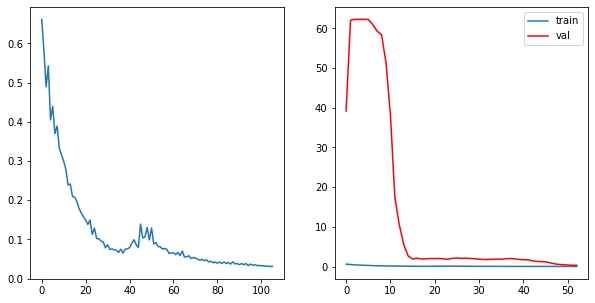

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0305, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0308, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 53	 \Training Loss: 0.030672972090542316	     Validation Loss:0.32582035660743713	 \ LR:0.01	 \ IOU_train:0.9712865352630615	     IOU_val:0.8092443943023682


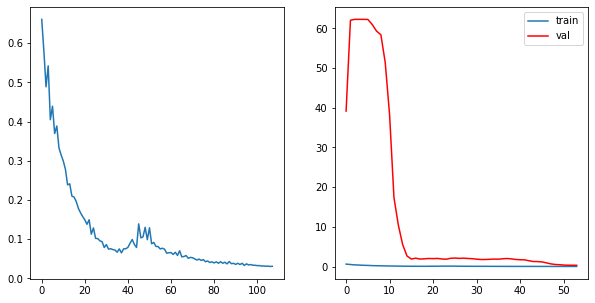

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0317, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0307, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 54	 \Training Loss: 0.031159507110714912	     Validation Loss:0.40385571122169495	 \ LR:0.01	 \ IOU_train:0.9710869789123535	     IOU_val:0.7910617589950562


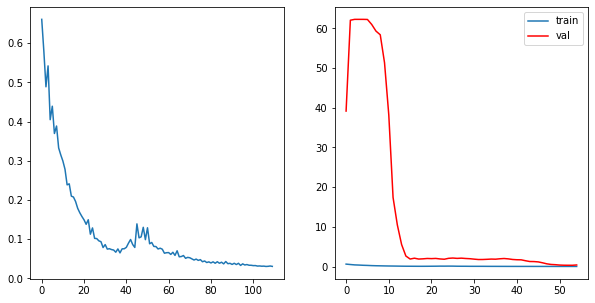

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0303, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0336, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 55	 \Training Loss: 0.0319520877674222	     Validation Loss:0.5897989273071289	 \ LR:0.01	 \ IOU_train:0.9702457189559937	     IOU_val:0.7687791585922241


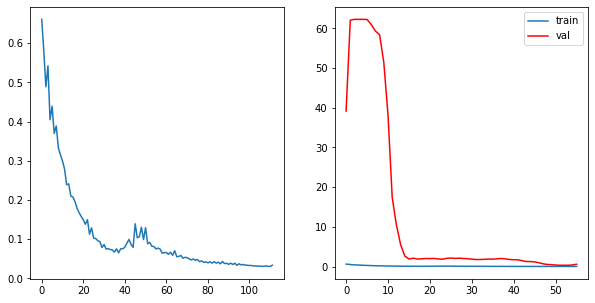

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0312, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0341, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 56	 \Training Loss: 0.0326457554474473	     Validation Loss:0.3225896954536438	 \ LR:0.01	 \ IOU_train:0.9696849584579468	     IOU_val:0.8137550950050354


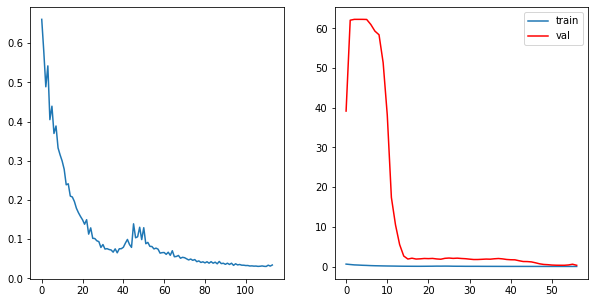

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0312, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0342, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 57	 \Training Loss: 0.03272434324026108	     Validation Loss:0.32003679871559143	 \ LR:0.01	 \ IOU_train:0.9685350656509399	     IOU_val:0.8170228004455566


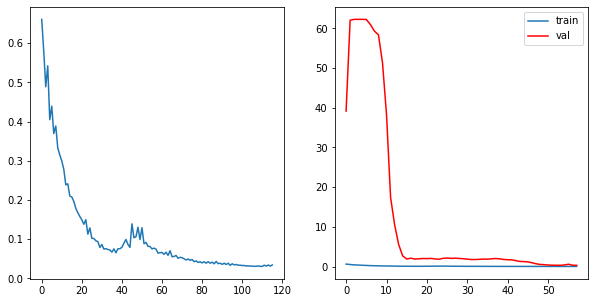

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0362, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0343, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 58	 \Training Loss: 0.03527041897177696	     Validation Loss:0.3479004502296448	 \ LR:0.01	 \ IOU_train:0.9674243330955505	     IOU_val:0.7924283742904663


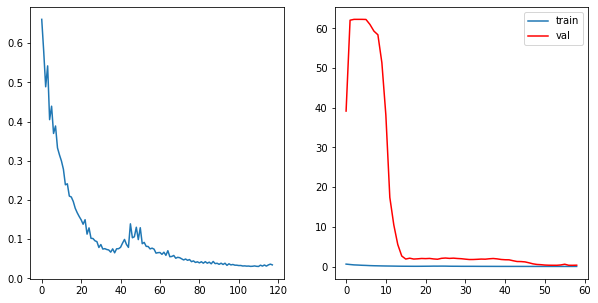

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0362, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0314, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 59	 \Training Loss: 0.03382118046283722	     Validation Loss:0.35168153047561646	 \ LR:0.01	 \ IOU_train:0.9680742621421814	     IOU_val:0.794352650642395


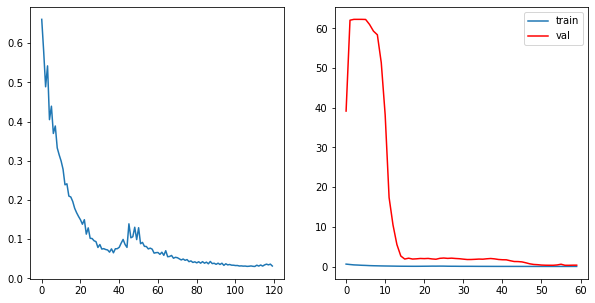

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0315, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0336, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 60	 \Training Loss: 0.03257918730378151	     Validation Loss:0.3993467390537262	 \ LR:0.01	 \ IOU_train:0.970224142074585	     IOU_val:0.7707656621932983


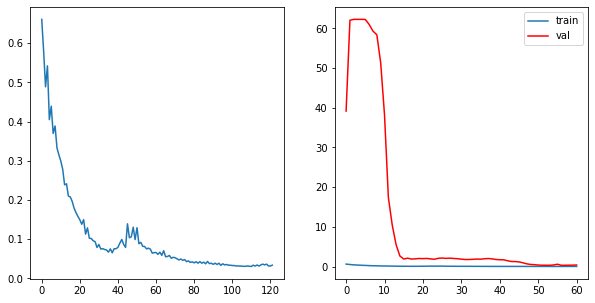

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0321, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0302, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 61	 \Training Loss: 0.031137241050601006	     Validation Loss:2.276083469390869	 \ LR:0.01	 \ IOU_train:0.9704387187957764	     IOU_val:0.6382941007614136


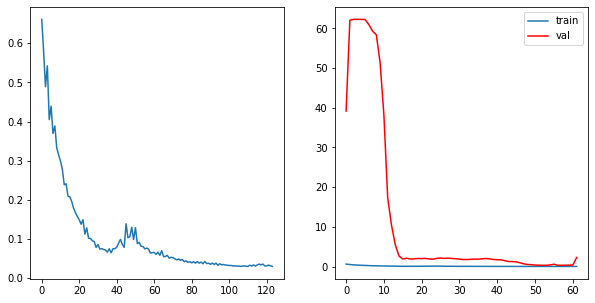

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0324, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0318, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 62	 \Training Loss: 0.03209769167006016	     Validation Loss:2.440040349960327	 \ LR:0.01	 \ IOU_train:0.9694974422454834	     IOU_val:0.645153284072876


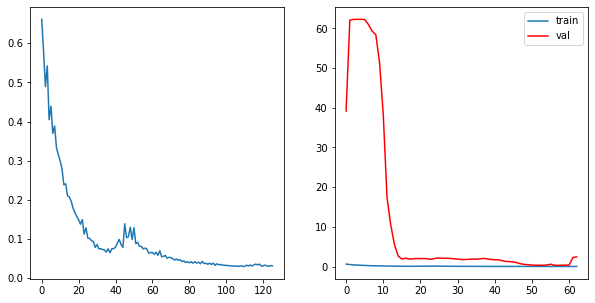

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0284, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0295, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 63	 \Training Loss: 0.028950217179954052	     Validation Loss:2.676429271697998	 \ LR:0.01	 \ IOU_train:0.9721816182136536	     IOU_val:0.6860290169715881


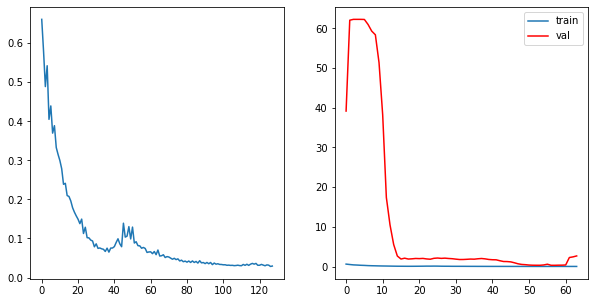

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0301, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0296, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 64	 \Training Loss: 0.029835883527994156	     Validation Loss:2.867849111557007	 \ LR:0.01	 \ IOU_train:0.9722979068756104	     IOU_val:0.6608954071998596


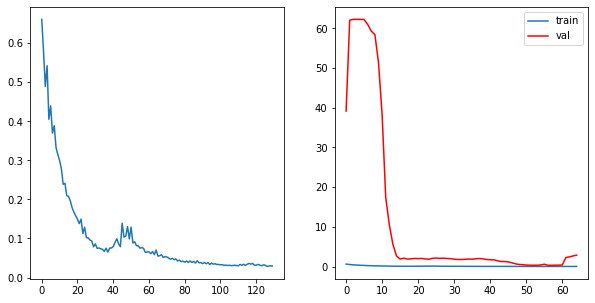

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0282, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0288, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 65	 \Training Loss: 0.02854175493121147	     Validation Loss:3.384998321533203	 \ LR:0.01	 \ IOU_train:0.9731119275093079	     IOU_val:0.5850563049316406


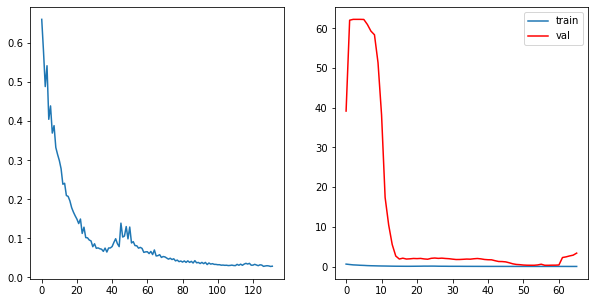

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0279, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0281, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 66	 \Training Loss: 0.02801288664340973	     Validation Loss:3.3898825645446777	 \ LR:0.01	 \ IOU_train:0.9736247062683105	     IOU_val:0.5599717497825623


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0276, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0283, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 67	 \Training Loss: 0.0279432637616992	     Validation Loss:2.9987480640411377	 \ LR:0.01	 \ IOU_train:0.9735046625137329	     IOU_val:0.6503148078918457


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0277, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0302, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 68	 \Training Loss: 0.028980660252273083	     Validation Loss:3.1129848957061768	 \ LR:0.001	 \ IOU_train:0.9725874662399292	     IOU_val:0.6716854572296143


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0275, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0279, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 69	 \Training Loss: 0.02773222979158163	     Validation Loss:3.426034450531006	 \ LR:0.001	 \ IOU_train:0.97403484582901	     IOU_val:0.6586712598800659


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0269, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0269, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 70	 \Training Loss: 0.0268726060166955	     Validation Loss:3.72655987739563	 \ LR:0.001	 \ IOU_train:0.9748948216438293	     IOU_val:0.6419311761856079


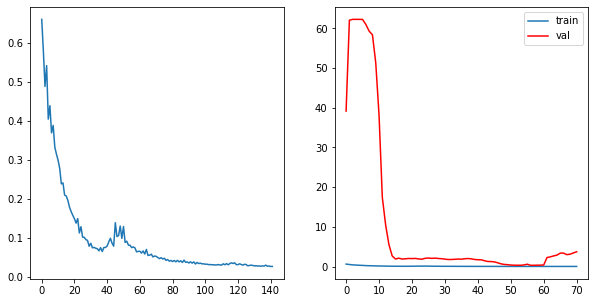

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0256, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0262, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 71	 \Training Loss: 0.02593935653567314	     Validation Loss:3.9564754962921143	 \ LR:0.001	 \ IOU_train:0.9757388830184937	     IOU_val:0.6242442727088928


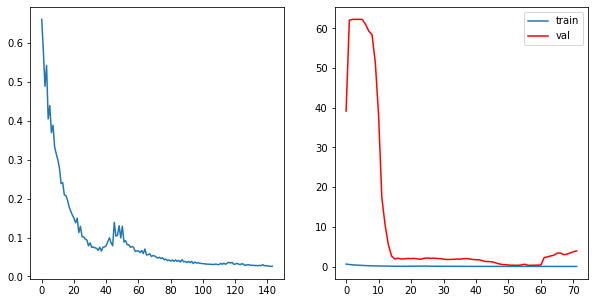

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0255, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0265, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 72	 \Training Loss: 0.025988060049712658	     Validation Loss:4.179850101470947	 \ LR:0.001	 \ IOU_train:0.9758663177490234	     IOU_val:0.6048396229743958


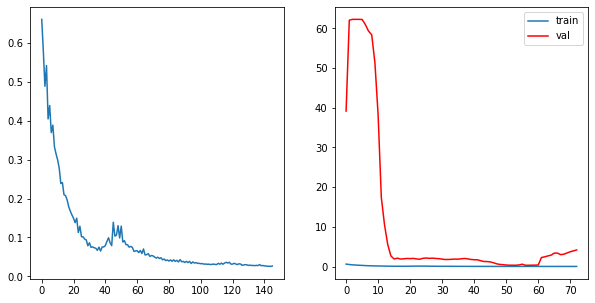

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0257, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0259, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 73	 \Training Loss: 0.025796868838369846	     Validation Loss:4.349048614501953	 \ LR:0.001	 \ IOU_train:0.9759833216667175	     IOU_val:0.5821269750595093


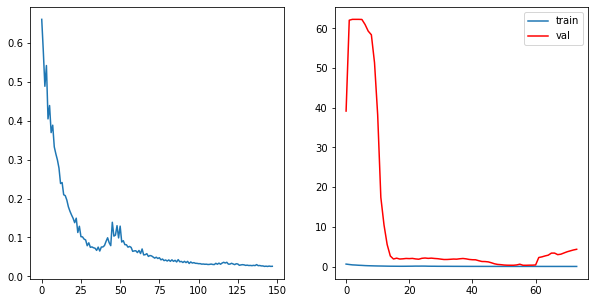

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0256, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0260, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 74	 \Training Loss: 0.025815336033701897	     Validation Loss:4.3925981521606445	 \ LR:0.001	 \ IOU_train:0.9758622646331787	     IOU_val:0.5616211891174316


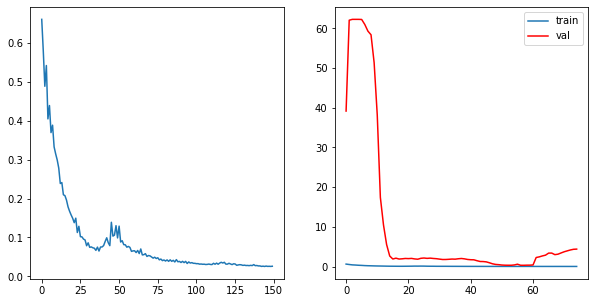

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0253, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0258, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 75	 \Training Loss: 0.02557565923780203	     Validation Loss:4.4337358474731445	 \ LR:0.001	 \ IOU_train:0.976264476776123	     IOU_val:0.5465661287307739


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0252, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0259, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 76	 \Training Loss: 0.025549132376909256	     Validation Loss:4.518154144287109	 \ LR:0.001	 \ IOU_train:0.9761799573898315	     IOU_val:0.5367670655250549


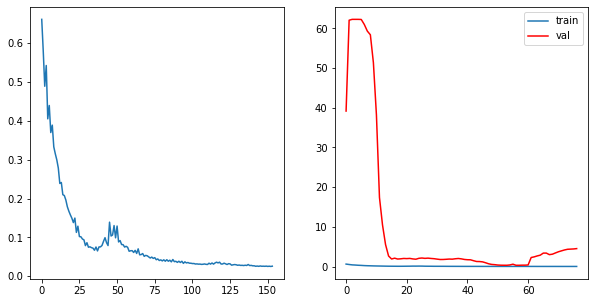

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0247, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0253, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 77	 \Training Loss: 0.025009232573211193	     Validation Loss:4.628524303436279	 \ LR:0.001	 \ IOU_train:0.9768446683883667	     IOU_val:0.5309412479400635


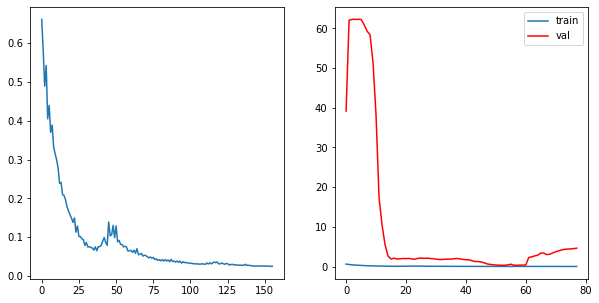

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0244, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0254, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 78	 \Training Loss: 0.024903840385377407	     Validation Loss:4.7678327560424805	 \ LR:0.001	 \ IOU_train:0.9770210385322571	     IOU_val:0.5263007283210754


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0250, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0255, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 79	 \Training Loss: 0.025244883261621	     Validation Loss:4.955516815185547	 \ LR:0.0001	 \ IOU_train:0.976601779460907	     IOU_val:0.5236687660217285


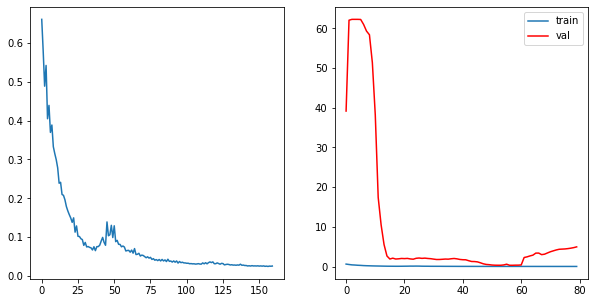

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0245, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0252, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 80	 \Training Loss: 0.024857635609805584	     Validation Loss:5.182108402252197	 \ LR:0.0001	 \ IOU_train:0.9770544767379761	     IOU_val:0.5180184245109558


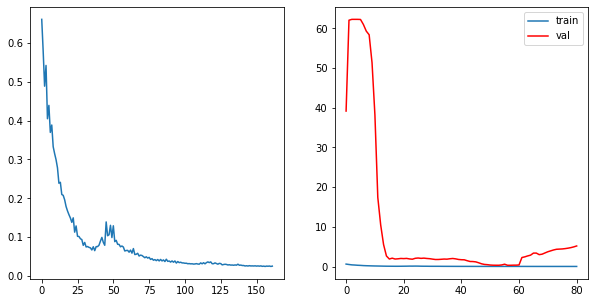

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0248, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0250, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 81	 \Training Loss: 0.024906021542847157	     Validation Loss:5.389911651611328	 \ LR:0.0001	 \ IOU_train:0.9767694473266602	     IOU_val:0.5108375549316406


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0246, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0249, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 82	 \Training Loss: 0.024737799540162086	     Validation Loss:5.587753772735596	 \ LR:0.0001	 \ IOU_train:0.9771180152893066	     IOU_val:0.5038129091262817


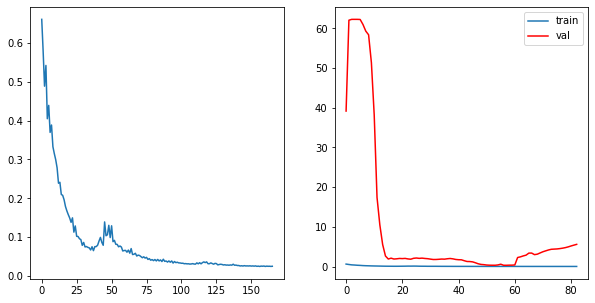

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0244, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0249, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 83	 \Training Loss: 0.024651356041431427	     Validation Loss:5.7704362869262695	 \ LR:0.0001	 \ IOU_train:0.9775809049606323	     IOU_val:0.49788898229599


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0249, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0250, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 84	 \Training Loss: 0.024917283095419407	     Validation Loss:5.938157558441162	 \ LR:0.0001	 \ IOU_train:0.9769715666770935	     IOU_val:0.492535263299942


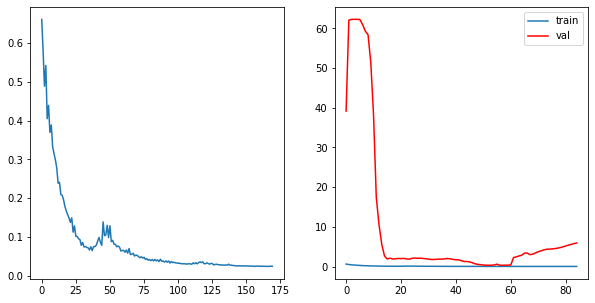

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0243, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0247, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 85	 \Training Loss: 0.024530330672860146	     Validation Loss:6.065108776092529	 \ LR:0.0001	 \ IOU_train:0.9775370359420776	     IOU_val:0.48799020051956177


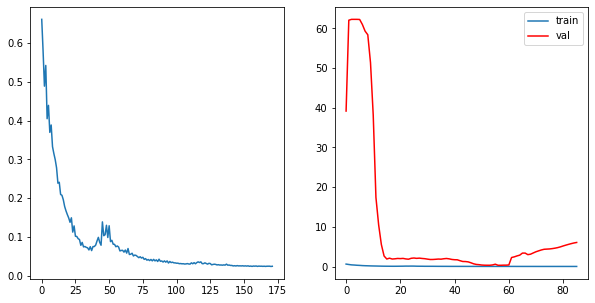

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0247, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0248, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 86	 \Training Loss: 0.024775956757366657	     Validation Loss:6.2113728523254395	 \ LR:0.0001	 \ IOU_train:0.9770894050598145	     IOU_val:0.48391905426979065


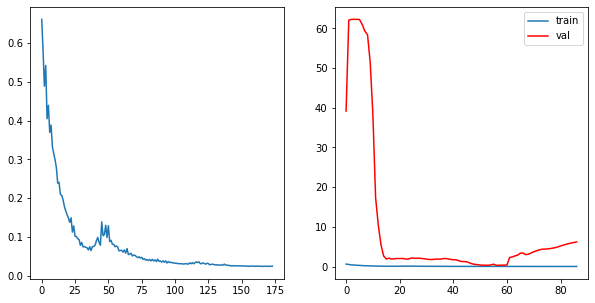

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0244, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0250, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 87	 \Training Loss: 0.024716567248106003	     Validation Loss:6.3640875816345215	 \ LR:0.0001	 \ IOU_train:0.9772670269012451	     IOU_val:0.4811103343963623


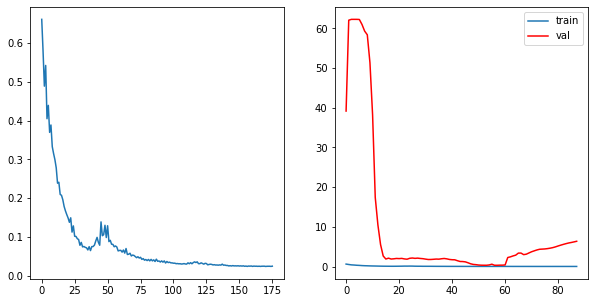

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0245, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0249, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 88	 \Training Loss: 0.02470181044191122	     Validation Loss:6.527065277099609	 \ LR:0.0001	 \ IOU_train:0.9770727753639221	     IOU_val:0.4777229428291321


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0242, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0251, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 89	 \Training Loss: 0.02465155068784952	     Validation Loss:6.657701015472412	 \ LR:0.0001	 \ IOU_train:0.9772313833236694	     IOU_val:0.47384268045425415


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0250, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0248, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 90	 \Training Loss: 0.024936260655522346	     Validation Loss:6.774518013000488	 \ LR:1e-05	 \ IOU_train:0.976722002029419	     IOU_val:0.47127261757850647


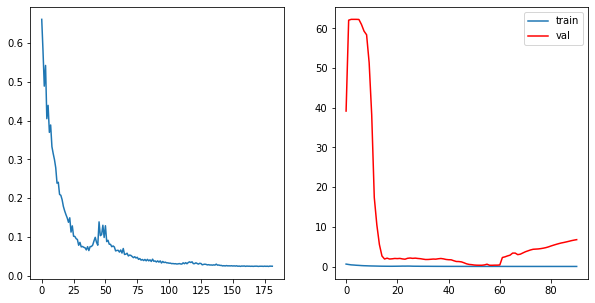

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0243, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0249, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 91	 \Training Loss: 0.024576966650784016	     Validation Loss:6.876857757568359	 \ LR:1e-05	 \ IOU_train:0.9773698449134827	     IOU_val:0.46967482566833496


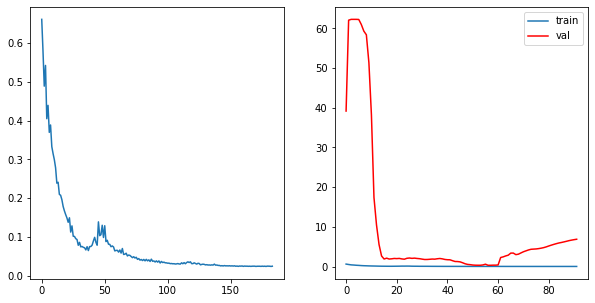

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0243, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0249, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 92	 \Training Loss: 0.024581920355558395	     Validation Loss:6.9749321937561035	 \ LR:1e-05	 \ IOU_train:0.9773896336555481	     IOU_val:0.46798577904701233


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0247, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0251, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 93	 \Training Loss: 0.024895984679460526	     Validation Loss:7.054581642150879	 \ LR:1e-05	 \ IOU_train:0.9770561456680298	     IOU_val:0.4664149582386017


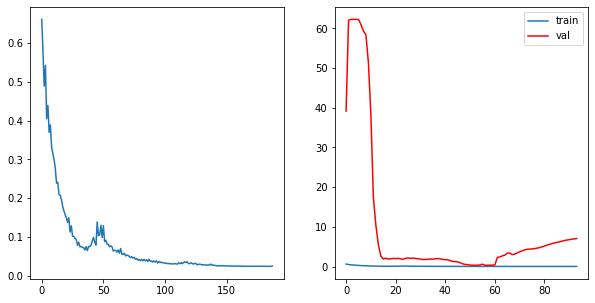

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0244, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0248, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 94	 \Training Loss: 0.024613399989902973	     Validation Loss:7.138719081878662	 \ LR:1e-05	 \ IOU_train:0.9772555828094482	     IOU_val:0.4651685059070587


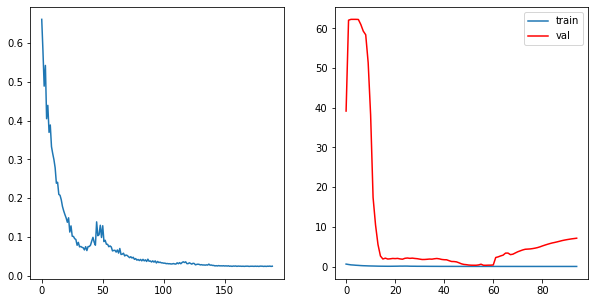

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0244, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0249, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 95	 \Training Loss: 0.02462779637426138	     Validation Loss:7.216497898101807	 \ LR:1e-05	 \ IOU_train:0.9772510528564453	     IOU_val:0.4639321565628052


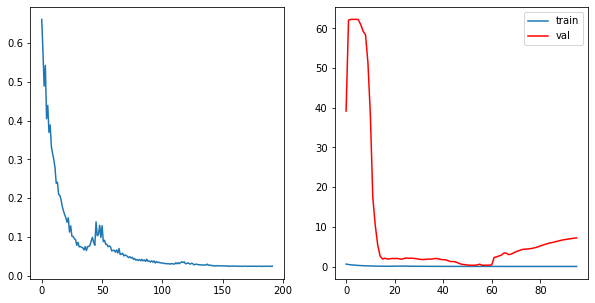

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0245, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0249, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 96	 \Training Loss: 0.024698090739548206	     Validation Loss:7.276466369628906	 \ LR:1e-05	 \ IOU_train:0.9773173332214355	     IOU_val:0.4629024267196655


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0244, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0247, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 97	 \Training Loss: 0.0245785191655159	     Validation Loss:7.329242706298828	 \ LR:1e-05	 \ IOU_train:0.9772278070449829	     IOU_val:0.46218520402908325


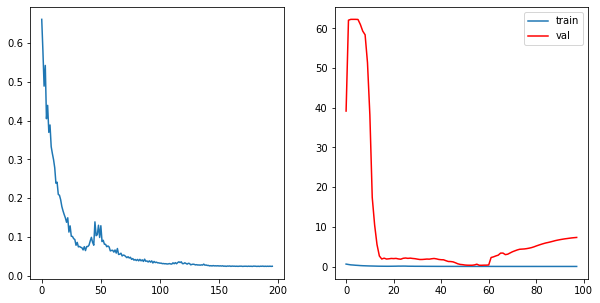

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0243, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0250, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 98	 \Training Loss: 0.024635234847664833	     Validation Loss:7.379864692687988	 \ LR:1e-05	 \ IOU_train:0.9772677421569824	     IOU_val:0.4616008400917053


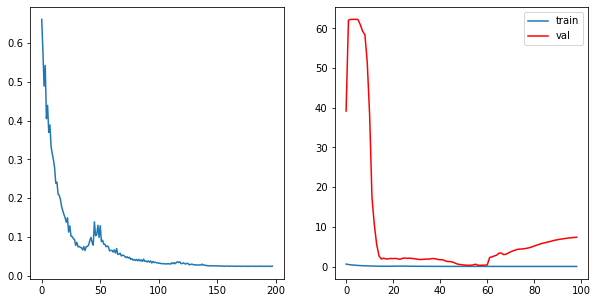

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0245, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0249, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 99	 \Training Loss: 0.02471640706062317	     Validation Loss:7.419295310974121	 \ LR:1e-05	 \ IOU_train:0.9771203398704529	     IOU_val:0.46115654706954956


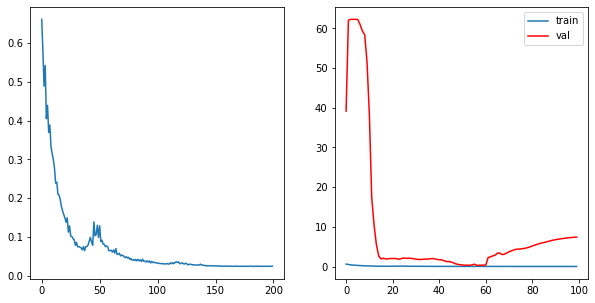

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0244, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0247, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 100	 \Training Loss: 0.024561879225075245	     Validation Loss:7.471243381500244	 \ LR:1e-05	 \ IOU_train:0.9774872064590454	     IOU_val:0.4600670337677002


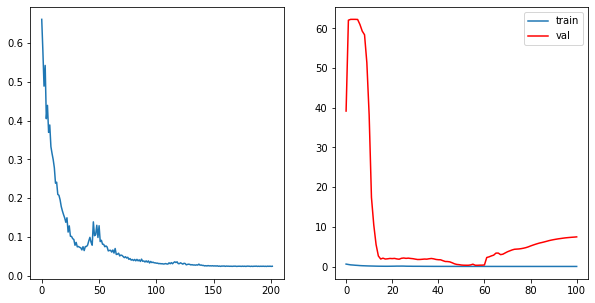

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0243, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0249, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 101	 \Training Loss: 0.02461273968219757	     Validation Loss:7.502130031585693	 \ LR:1.0000000000000002e-06	 \ IOU_train:0.9773653149604797	     IOU_val:0.4598201513290405


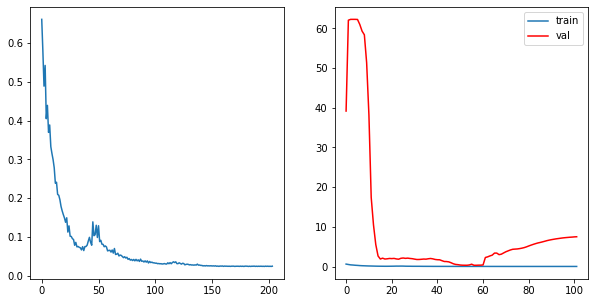

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0245, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0248, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 102	 \Training Loss: 0.024640437215566635	     Validation Loss:7.532825469970703	 \ LR:1.0000000000000002e-06	 \ IOU_train:0.9773225784301758	     IOU_val:0.4596450626850128


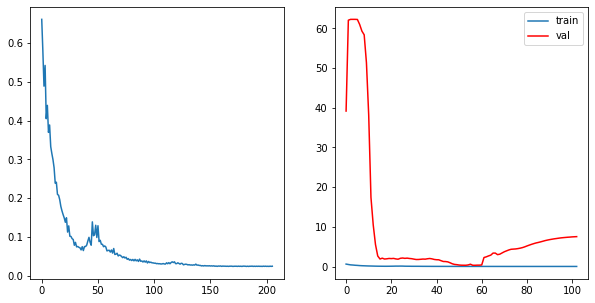

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0245, grad_fn=<BinaryCrossEntropyBackward0>)


KeyboardInterrupt: 

In [110]:
from tqdm.notebook import tqdm
step_losses = []
epoch_losses_train = []
epoch_losses_val = []

for epoch in tqdm(range(epochs)):
    epoch_loss = 0
    epoch_loss_test = 0
    jaccard_train = []
    jaccard_val = []
    model.train()
    for X, Y in tqdm(data_loader, total=len(data_loader)):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        step_losses.append(loss.item())
        print(loss)
        jaccard_train.append(jaccard(Y_pred, Y.int()))
    if epoch % 5 == 0:
        state = {'info':  "house baseline_"+str(optimizer.param_groups[0]['lr']),            # описание
         'date':      datetime.datetime.now(),   # дата и время
         'model' :    model.state_dict(),        # параметры модели
         'optimizer': optimizer.state_dict()}    # состояние оптимизатора
        torch.save(state, '/house_baseline_' + str(epoch)+ '.pth')
    with torch.no_grad():
        model.eval()
        for X, Y in tqdm(data_loader_val, total=len(data_loader_val), leave=False):
            X, Y = X.to(device), Y.to(device)
            Y_pred = model(X)
            loss_test = criterion(Y_pred, Y)
            epoch_loss_test += loss_test.item()
            jaccard_val.append(jaccard(Y_pred, Y.int()))
    epoch_losses_val.append(epoch_loss_test/len(data_loader_val))
    epoch_losses_train.append(epoch_loss/len(data_loader))
    scheduler.step(epoch_loss_test/len(data_loader_val))
    curr_lr = optimizer.param_groups[0]['lr']
  
    print(f'Epoch {epoch}\t \Training Loss: {epoch_loss/len(data_loader)}\t \
    Validation Loss:{epoch_loss_test/len(data_loader_val)}\t \ LR:{curr_lr}\t \ IOU_train:{sum(jaccard_train)/len(data_loader)}\t \
    IOU_val:{sum(jaccard_val)/len(data_loader_val)}')
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].plot(step_losses)
    axes[1].plot(epoch_losses_train, label = 'train')
    axes[1].plot(epoch_losses_val, color = 'red', label = 'val')
    axes[1].legend()
    plt.show()


Второй эксперимент: UNet с механизмом внимания с добавением аугументаций

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.6977, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.8776, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.3850), tensor(0.3397)]
IOU_val:  [tensor(0.1242)]
Epoch 0	 \Training Loss: 0.7876225113868713	     Validation Loss:75.19474792480469	 \ LR:0.01	 \ IOU_train:0.3623291254043579	     IOU_val:0.1242344006896019


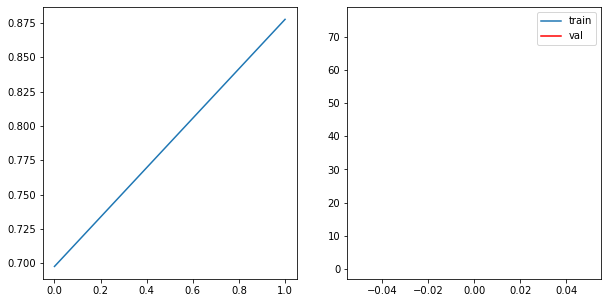

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.4602, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5657, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.6023), tensor(0.5363)]
IOU_val:  [tensor(0.3749)]
Epoch 1	 \Training Loss: 0.5129354596138	     Validation Loss:24.994243621826172	 \ LR:0.01	 \ IOU_train:0.5692605972290039	     IOU_val:0.3749237060546875


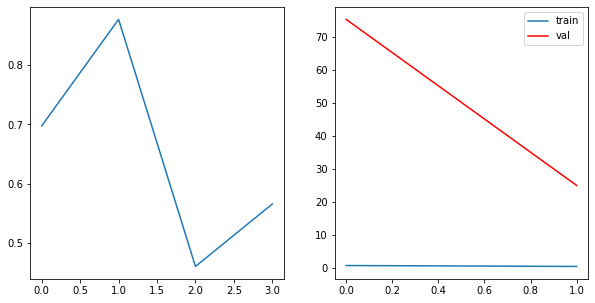

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.4274, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3930, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.5992), tensor(0.6449)]
IOU_val:  [tensor(0.3082)]
Epoch 2	 \Training Loss: 0.4102051258087158	     Validation Loss:51.22147750854492	 \ LR:0.01	 \ IOU_train:0.6220439672470093	     IOU_val:0.3082441985607147


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.3538, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3514, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.6743), tensor(0.7085)]
IOU_val:  [tensor(0.1243)]
Epoch 3	 \Training Loss: 0.3526066988706589	     Validation Loss:74.64559173583984	 \ LR:0.01	 \ IOU_train:0.691431999206543	     IOU_val:0.12427528947591782


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.3235, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3297, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.7211), tensor(0.7160)]
IOU_val:  [tensor(0.1265)]
Epoch 4	 \Training Loss: 0.3266298770904541	     Validation Loss:72.68721008300781	 \ LR:0.01	 \ IOU_train:0.7185150384902954	     IOU_val:0.12649869918823242


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.2848, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3020, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.7466), tensor(0.7397)]
IOU_val:  [tensor(0.1272)]
Epoch 5	 \Training Loss: 0.2933908551931381	     Validation Loss:72.54060363769531	 \ LR:0.01	 \ IOU_train:0.7431552410125732	     IOU_val:0.12717284262180328


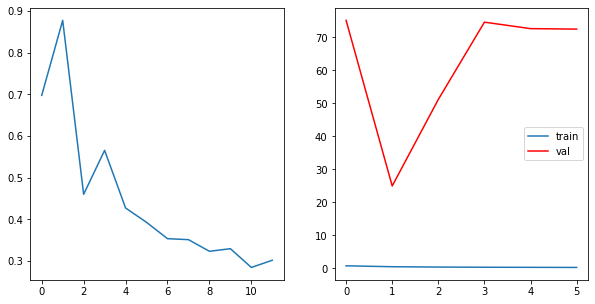

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.2711, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2874, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.7660), tensor(0.7502)]
IOU_val:  [tensor(0.1399)]
Epoch 6	 \Training Loss: 0.2792716473340988	     Validation Loss:67.07023620605469	 \ LR:0.01	 \ IOU_train:0.7581301331520081	     IOU_val:0.13992555439472198


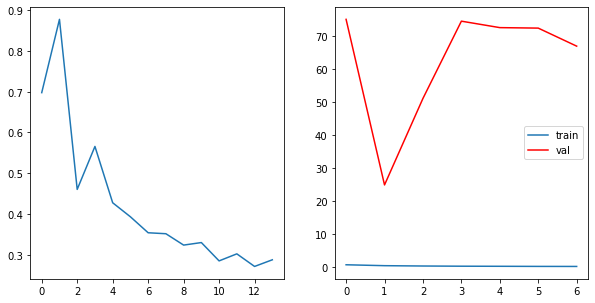

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.2491, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2868, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.7831), tensor(0.7544)]
IOU_val:  [tensor(0.1761)]
Epoch 7	 \Training Loss: 0.2679171562194824	     Validation Loss:56.55487823486328	 \ LR:0.01	 \ IOU_train:0.7687350511550903	     IOU_val:0.17607073485851288


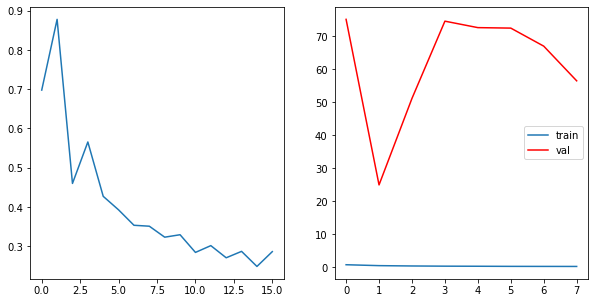

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.2365, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2720, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.7971), tensor(0.7768)]
IOU_val:  [tensor(0.2347)]
Epoch 8	 \Training Loss: 0.2542231008410454	     Validation Loss:28.167728424072266	 \ LR:0.01	 \ IOU_train:0.7869412899017334	     IOU_val:0.2346845418214798


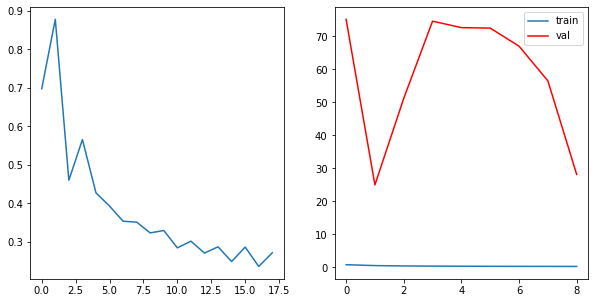

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.2198, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2386, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.8142), tensor(0.8004)]
IOU_val:  [tensor(0.3844)]
Epoch 9	 \Training Loss: 0.22920452803373337	     Validation Loss:2.818450450897217	 \ LR:0.01	 \ IOU_train:0.8073049783706665	     IOU_val:0.3844255805015564


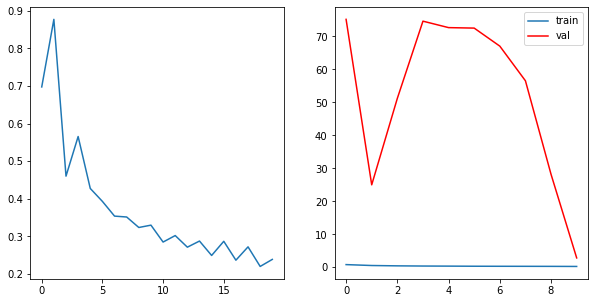

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.2151, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2615, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.8140), tensor(0.7863)]
IOU_val:  [tensor(0.4999)]
Epoch 10	 \Training Loss: 0.2383090704679489	     Validation Loss:1.5532312393188477	 \ LR:0.01	 \ IOU_train:0.8001632690429688	     IOU_val:0.4999447464942932


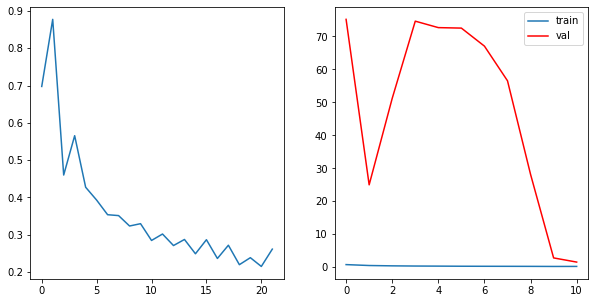

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.1964, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2513, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.8288), tensor(0.7926)]
IOU_val:  [tensor(0.3523)]
Epoch 11	 \Training Loss: 0.2238542139530182	     Validation Loss:10.569804191589355	 \ LR:0.01	 \ IOU_train:0.8107082843780518	     IOU_val:0.3523431420326233


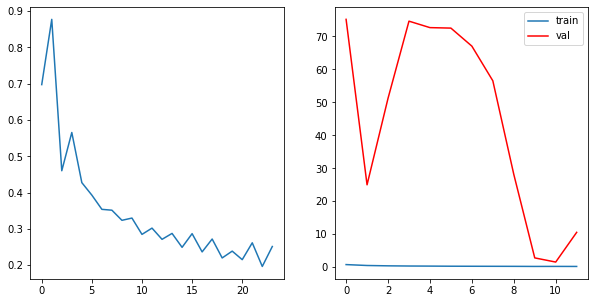

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.1922, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2095, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.8362), tensor(0.8269)]
IOU_val:  [tensor(0.3681)]
Epoch 12	 \Training Loss: 0.20082597434520721	     Validation Loss:12.156634330749512	 \ LR:0.01	 \ IOU_train:0.8315345048904419	     IOU_val:0.36813944578170776


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.1948, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2386, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.8371), tensor(0.7988)]
IOU_val:  [tensor(0.4348)]
Epoch 13	 \Training Loss: 0.21668703854084015	     Validation Loss:2.9831228256225586	 \ LR:0.01	 \ IOU_train:0.8179683685302734	     IOU_val:0.434756338596344


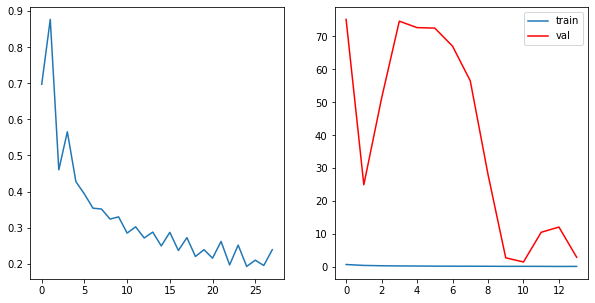

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.1742, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2176, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.8487), tensor(0.8149)]
IOU_val:  [tensor(0.5983)]
Epoch 14	 \Training Loss: 0.1958678588271141	     Validation Loss:0.8968251347541809	 \ LR:0.01	 \ IOU_train:0.8317978978157043	     IOU_val:0.5983397364616394


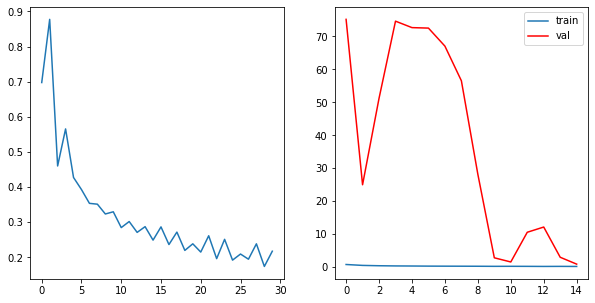

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.1696, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1961, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.8590), tensor(0.8325)]
IOU_val:  [tensor(0.6746)]
Epoch 15	 \Training Loss: 0.18285798281431198	     Validation Loss:0.8489258885383606	 \ LR:0.01	 \ IOU_train:0.8457402586936951	     IOU_val:0.6745984554290771


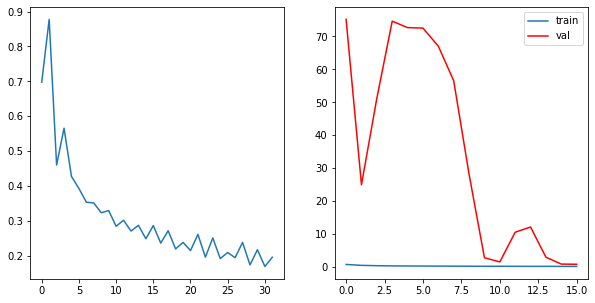

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.1691, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1914, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.8563), tensor(0.8409)]
IOU_val:  [tensor(0.6605)]
Epoch 16	 \Training Loss: 0.1802743524312973	     Validation Loss:0.7229772210121155	 \ LR:0.01	 \ IOU_train:0.8486078977584839	     IOU_val:0.660538911819458


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.1642, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1921, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.8590), tensor(0.8369)]
IOU_val:  [tensor(0.6470)]
Epoch 17	 \Training Loss: 0.178165040910244	     Validation Loss:0.7885667681694031	 \ LR:0.01	 \ IOU_train:0.8479654788970947	     IOU_val:0.6470010280609131


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.1529, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1713, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.8658), tensor(0.8577)]
IOU_val:  [tensor(0.6928)]
Epoch 18	 \Training Loss: 0.16212411224842072	     Validation Loss:0.5384537577629089	 \ LR:0.01	 \ IOU_train:0.8617781400680542	     IOU_val:0.692846417427063


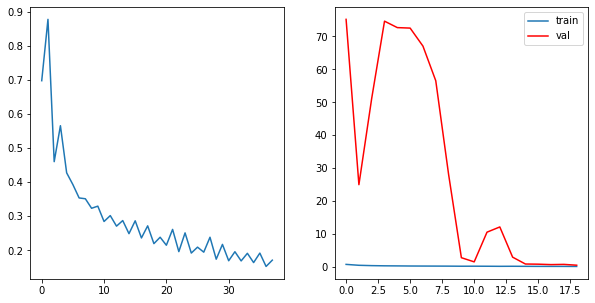

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.1391, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1657, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.8815), tensor(0.8581)]
IOU_val:  [tensor(0.6951)]
Epoch 19	 \Training Loss: 0.15239250659942627	     Validation Loss:0.5805018544197083	 \ LR:0.01	 \ IOU_train:0.8698263168334961	     IOU_val:0.6951428651809692


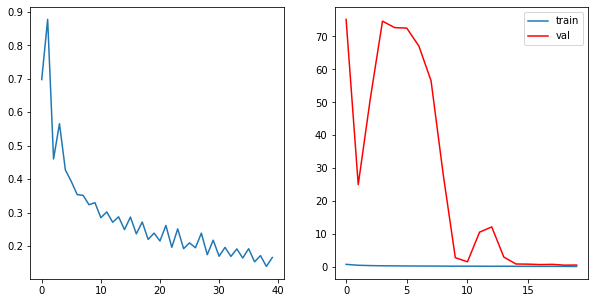

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.1403, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1546, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.8782), tensor(0.8641)]
IOU_val:  [tensor(0.6873)]
Epoch 20	 \Training Loss: 0.14749671518802643	     Validation Loss:0.6684648394584656	 \ LR:0.01	 \ IOU_train:0.8711245059967041	     IOU_val:0.687256932258606


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.1367, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1621, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.8791), tensor(0.8604)]
IOU_val:  [tensor(0.6603)]
Epoch 21	 \Training Loss: 0.14938780665397644	     Validation Loss:0.7721059918403625	 \ LR:0.01	 \ IOU_train:0.8697495460510254	     IOU_val:0.6603206396102905


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.1334, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1669, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.8819), tensor(0.8684)]
IOU_val:  [tensor(0.6649)]
Epoch 22	 \Training Loss: 0.1501733660697937	     Validation Loss:0.719052255153656	 \ LR:0.01	 \ IOU_train:0.8751535415649414	     IOU_val:0.6648532748222351


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.1329, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1465, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.8861), tensor(0.8757)]
IOU_val:  [tensor(0.7200)]
Epoch 23	 \Training Loss: 0.13966644555330276	     Validation Loss:0.4663170874118805	 \ LR:0.01	 \ IOU_train:0.8809224963188171	     IOU_val:0.7200230360031128


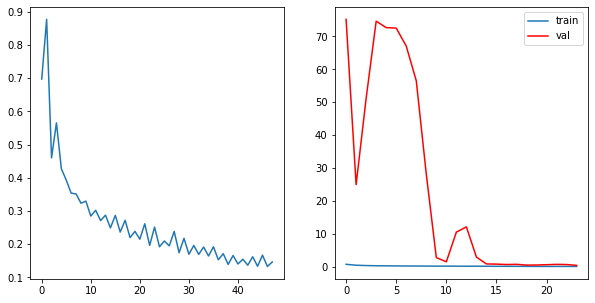

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.1279, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1380, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.8870), tensor(0.8846)]
IOU_val:  [tensor(0.7039)]
Epoch 24	 \Training Loss: 0.1329646036028862	     Validation Loss:0.633647620677948	 \ LR:0.01	 \ IOU_train:0.8858043551445007	     IOU_val:0.7038841247558594


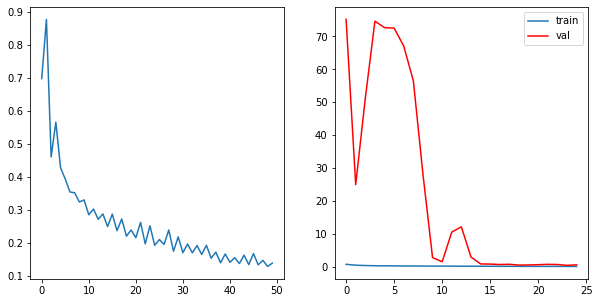

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.1241, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1473, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.8918), tensor(0.8811)]
IOU_val:  [tensor(0.7794)]
Epoch 25	 \Training Loss: 0.1356903612613678	     Validation Loss:0.31318801641464233	 \ LR:0.01	 \ IOU_train:0.886439323425293	     IOU_val:0.7793525457382202


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.1110, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1464, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.9048), tensor(0.8700)]
IOU_val:  [tensor(0.7811)]
Epoch 26	 \Training Loss: 0.1286957636475563	     Validation Loss:0.2553333640098572	 \ LR:0.01	 \ IOU_train:0.8873908519744873	     IOU_val:0.7810626029968262


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.1133, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1452, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.9091), tensor(0.8753)]
IOU_val:  [tensor(0.8558)]
Epoch 27	 \Training Loss: 0.12925485521554947	     Validation Loss:0.16556401550769806	 \ LR:0.01	 \ IOU_train:0.8922128677368164	     IOU_val:0.85582435131073


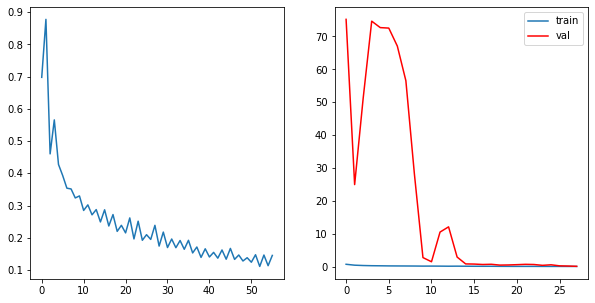

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.1113, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1177, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.9099), tensor(0.9014)]
IOU_val:  [tensor(0.7810)]
Epoch 28	 \Training Loss: 0.1144815944135189	     Validation Loss:0.2957690954208374	 \ LR:0.01	 \ IOU_train:0.9056450128555298	     IOU_val:0.7810262441635132


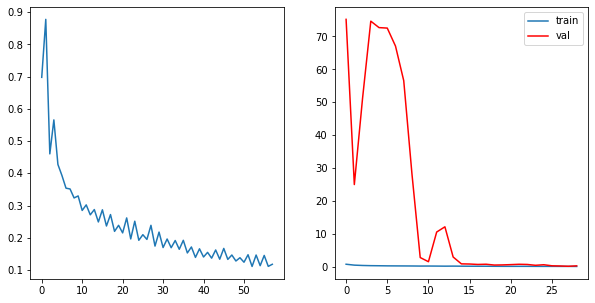

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.1174, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1367, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.9011), tensor(0.8819)]
IOU_val:  [tensor(0.8330)]
Epoch 29	 \Training Loss: 0.12704895809292793	     Validation Loss:0.22107872366905212	 \ LR:0.01	 \ IOU_train:0.8914944529533386	     IOU_val:0.832996129989624


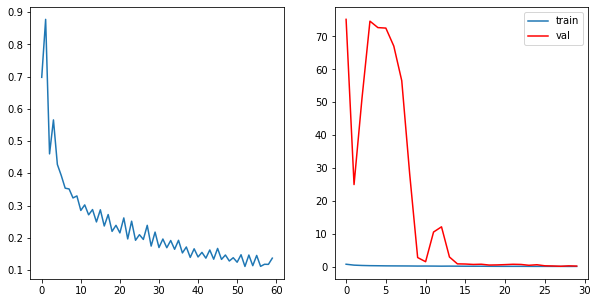

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.1064, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1077, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.9078), tensor(0.9036)]
IOU_val:  [tensor(0.8269)]
Epoch 30	 \Training Loss: 0.10703081265091896	     Validation Loss:0.19789685308933258	 \ LR:0.01	 \ IOU_train:0.9057363271713257	     IOU_val:0.826919674873352


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.1102, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1328, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.9087), tensor(0.8892)]
IOU_val:  [tensor(0.7902)]
Epoch 31	 \Training Loss: 0.12150571495294571	     Validation Loss:0.304420530796051	 \ LR:0.01	 \ IOU_train:0.8989467024803162	     IOU_val:0.7901555299758911


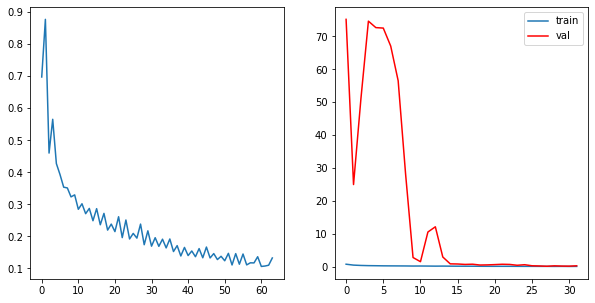

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.1036, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1459, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.9087), tensor(0.8730)]
IOU_val:  [tensor(0.8277)]
Epoch 32	 \Training Loss: 0.12478694319725037	     Validation Loss:0.2106858193874359	 \ LR:0.01	 \ IOU_train:0.89085453748703	     IOU_val:0.8277186751365662


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0971, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1251, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.9161), tensor(0.8827)]
IOU_val:  [tensor(0.8025)]
Epoch 33	 \Training Loss: 0.1111086830496788	     Validation Loss:0.22068707644939423	 \ LR:0.01	 \ IOU_train:0.8994325399398804	     IOU_val:0.8024983406066895


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.1051, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1158, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.9115), tensor(0.9028)]
IOU_val:  [tensor(0.7897)]
Epoch 34	 \Training Loss: 0.11049415543675423	     Validation Loss:0.33776912093162537	 \ LR:0.01	 \ IOU_train:0.9071502685546875	     IOU_val:0.7897264361381531


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0970, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1372, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.9161), tensor(0.8795)]
IOU_val:  [tensor(0.8476)]
Epoch 35	 \Training Loss: 0.1171032190322876	     Validation Loss:0.18577025830745697	 \ LR:0.01	 \ IOU_train:0.8978091478347778	     IOU_val:0.8476356863975525


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0911, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1042, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.9230), tensor(0.9105)]
IOU_val:  [tensor(0.8496)]
Epoch 36	 \Training Loss: 0.09767785668373108	     Validation Loss:0.18296024203300476	 \ LR:0.01	 \ IOU_train:0.9167870879173279	     IOU_val:0.8495543003082275


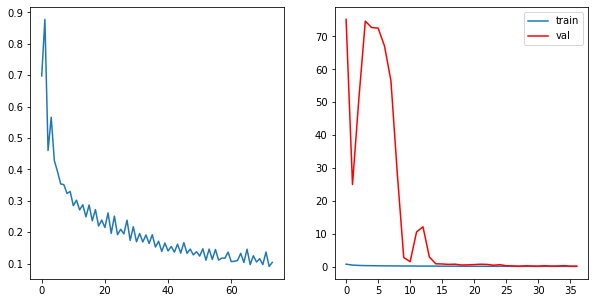

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.1073, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0850, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.9057), tensor(0.9259)]
IOU_val:  [tensor(0.8432)]
Epoch 37	 \Training Loss: 0.0961558185517788	     Validation Loss:0.1981429159641266	 \ LR:0.01	 \ IOU_train:0.9157799482345581	     IOU_val:0.8431721925735474


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0887, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0988, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.9208), tensor(0.9125)]
IOU_val:  [tensor(0.8083)]
Epoch 38	 \Training Loss: 0.09376673772931099	     Validation Loss:0.25433415174484253	 \ LR:0.001	 \ IOU_train:0.9166698455810547	     IOU_val:0.8083223104476929


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0912, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0832, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.9188), tensor(0.9297)]
IOU_val:  [tensor(0.8304)]
Epoch 39	 \Training Loss: 0.08719898760318756	     Validation Loss:0.20650318264961243	 \ LR:0.001	 \ IOU_train:0.9242455959320068	     IOU_val:0.8304490447044373


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0825, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0726, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.9274), tensor(0.9382)]
IOU_val:  [tensor(0.8400)]
Epoch 40	 \Training Loss: 0.07753313705325127	     Validation Loss:0.18141916394233704	 \ LR:0.001	 \ IOU_train:0.9328373670578003	     IOU_val:0.8399571776390076


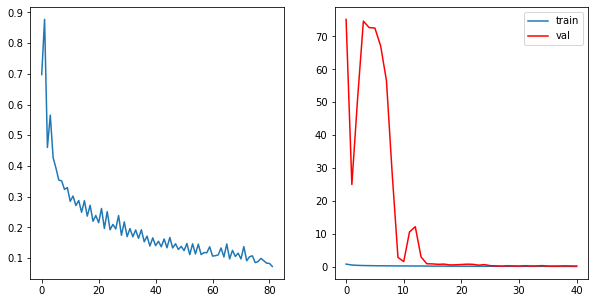

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0811, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0720, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.9308), tensor(0.9386)]
IOU_val:  [tensor(0.8557)]
Epoch 41	 \Training Loss: 0.07651583105325699	     Validation Loss:0.17061041295528412	 \ LR:0.001	 \ IOU_train:0.9347357749938965	     IOU_val:0.8556557297706604


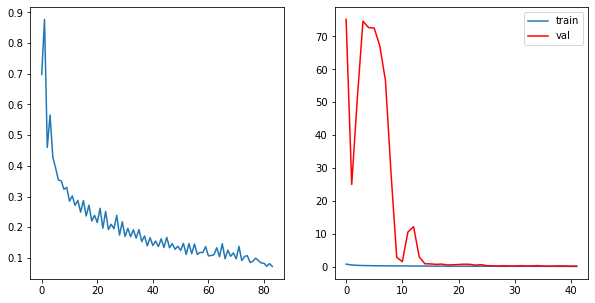

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0787, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0707, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.9305), tensor(0.9400)]
IOU_val:  [tensor(0.8557)]
Epoch 42	 \Training Loss: 0.07469631731510162	     Validation Loss:0.1742497831583023	 \ LR:0.001	 \ IOU_train:0.935296356678009	     IOU_val:0.8557460308074951


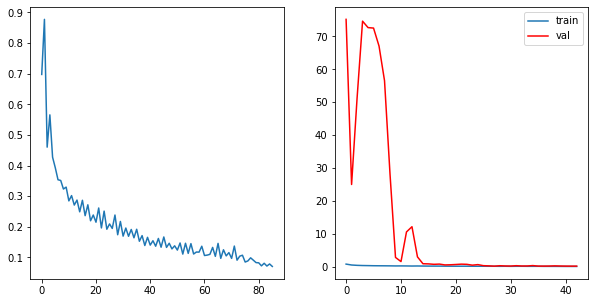

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0761, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0719, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.9341), tensor(0.9378)]
IOU_val:  [tensor(0.8589)]
Epoch 43	 \Training Loss: 0.07397661358118057	     Validation Loss:0.16041743755340576	 \ LR:0.001	 \ IOU_train:0.9359526038169861	     IOU_val:0.8589447736740112


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0741, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0678, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.9343), tensor(0.9419)]
IOU_val:  [tensor(0.8603)]
Epoch 44	 \Training Loss: 0.07094486802816391	     Validation Loss:0.15470197796821594	 \ LR:0.001	 \ IOU_train:0.9381403923034668	     IOU_val:0.8602601289749146


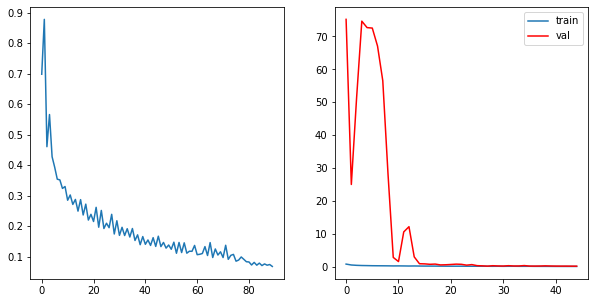

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0718, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0666, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.9390), tensor(0.9433)]
IOU_val:  [tensor(0.8689)]
Epoch 45	 \Training Loss: 0.06922686100006104	     Validation Loss:0.14081916213035583	 \ LR:0.001	 \ IOU_train:0.9411585330963135	     IOU_val:0.8688660860061646


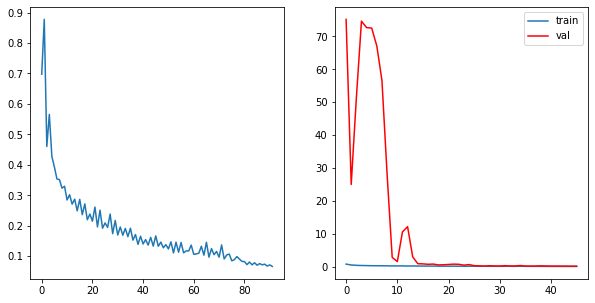

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0757, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0659, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.9346), tensor(0.9446)]
IOU_val:  [tensor(0.8637)]
Epoch 46	 \Training Loss: 0.07078633457422256	     Validation Loss:0.14619985222816467	 \ LR:0.001	 \ IOU_train:0.9396054744720459	     IOU_val:0.8636637330055237


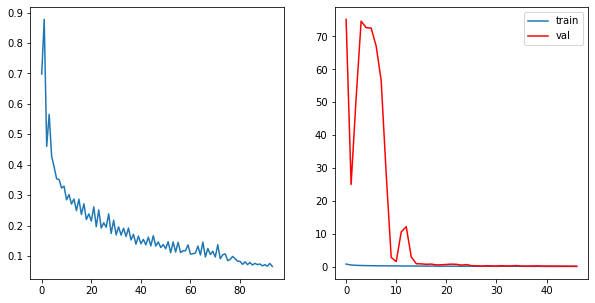

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0694, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0620, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.9414), tensor(0.9483)]
IOU_val:  [tensor(0.8687)]
Epoch 47	 \Training Loss: 0.0657108835875988	     Validation Loss:0.1414148062467575	 \ LR:0.001	 \ IOU_train:0.9448366761207581	     IOU_val:0.8687460422515869


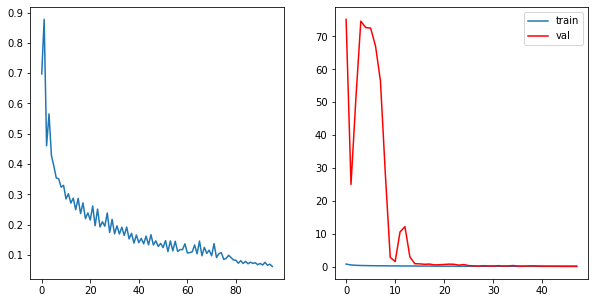

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0704, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0654, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.9398), tensor(0.9438)]
IOU_val:  [tensor(0.8665)]
Epoch 48	 \Training Loss: 0.06790906190872192	     Validation Loss:0.14447836577892303	 \ LR:0.001	 \ IOU_train:0.9417732357978821	     IOU_val:0.8665028214454651


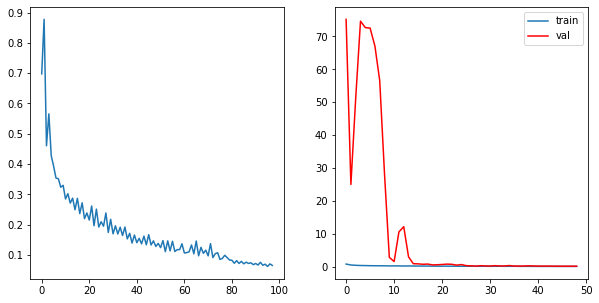

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0662, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0721, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.9433), tensor(0.9356)]
IOU_val:  [tensor(0.8686)]
Epoch 49	 \Training Loss: 0.06912392005324364	     Validation Loss:0.13955195248126984	 \ LR:0.001	 \ IOU_train:0.9394195079803467	     IOU_val:0.8686267733573914


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0701, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0620, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.9394), tensor(0.9483)]
IOU_val:  [tensor(0.8539)]
Epoch 50	 \Training Loss: 0.06608112156391144	     Validation Loss:0.15834927558898926	 \ LR:0.001	 \ IOU_train:0.943881630897522	     IOU_val:0.8538516163825989


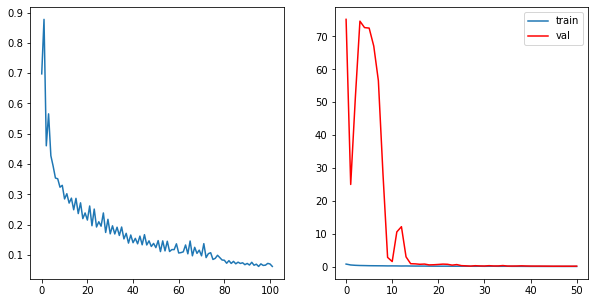

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0668, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0624, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.9431), tensor(0.9464)]
IOU_val:  [tensor(0.8707)]
Epoch 51	 \Training Loss: 0.06463191099464893	     Validation Loss:0.1391725242137909	 \ LR:0.001	 \ IOU_train:0.9447653293609619	     IOU_val:0.8707033395767212


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0648, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0626, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.9447), tensor(0.9473)]
IOU_val:  [tensor(0.8620)]
Epoch 52	 \Training Loss: 0.06367938965559006	     Validation Loss:0.15638019144535065	 \ LR:0.001	 \ IOU_train:0.9460136294364929	     IOU_val:0.8620082139968872


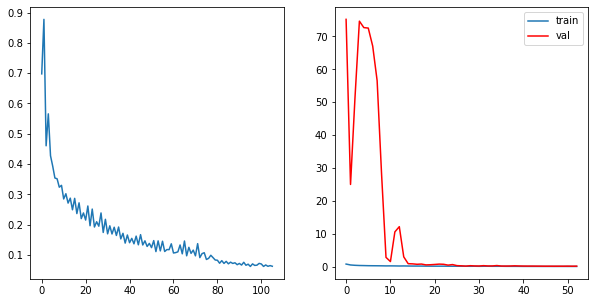

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0625, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0610, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.9463), tensor(0.9477)]
IOU_val:  [tensor(0.8407)]
Epoch 53	 \Training Loss: 0.061713676899671555	     Validation Loss:0.17834316194057465	 \ LR:0.001	 \ IOU_train:0.9469937086105347	     IOU_val:0.8406804203987122


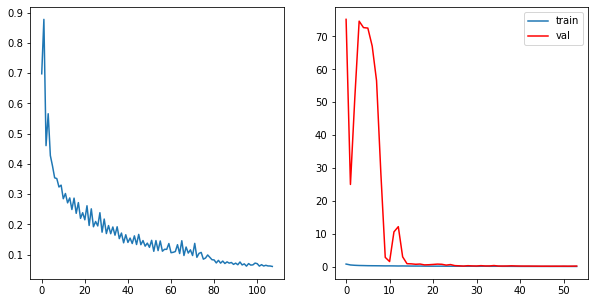

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0636, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0570, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.9466), tensor(0.9512)]
IOU_val:  [tensor(0.8523)]
Epoch 54	 \Training Loss: 0.06026784889400005	     Validation Loss:0.17411798238754272	 \ LR:0.001	 \ IOU_train:0.9489148259162903	     IOU_val:0.8523461818695068


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0613, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0593, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.9477), tensor(0.9483)]
IOU_val:  [tensor(0.8695)]
Epoch 55	 \Training Loss: 0.060287006199359894	     Validation Loss:0.13846656680107117	 \ LR:0.001	 \ IOU_train:0.9480170011520386	     IOU_val:0.8695445656776428


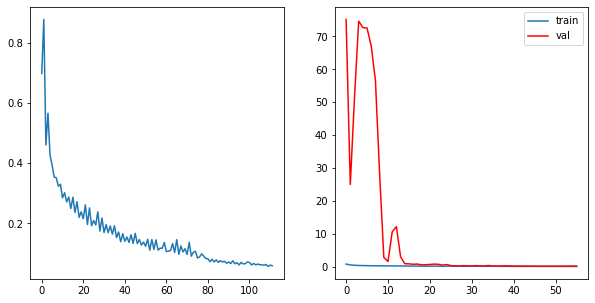

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0620, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0552, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.9482), tensor(0.9513)]
IOU_val:  [tensor(0.8675)]
Epoch 56	 \Training Loss: 0.05857845954596996	     Validation Loss:0.14268629252910614	 \ LR:0.001	 \ IOU_train:0.9497560262680054	     IOU_val:0.8675143718719482


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0609, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0526, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.9480), tensor(0.9547)]
IOU_val:  [tensor(0.8363)]
Epoch 57	 \Training Loss: 0.056749098002910614	     Validation Loss:0.18888108432292938	 \ LR:0.001	 \ IOU_train:0.9513651728630066	     IOU_val:0.8363440036773682


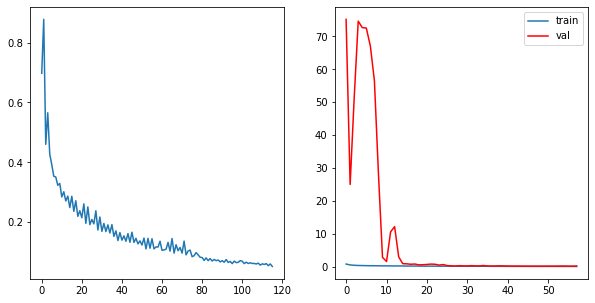

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0577, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0574, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.9514), tensor(0.9508)]
IOU_val:  [tensor(0.8664)]
Epoch 58	 \Training Loss: 0.05754023976624012	     Validation Loss:0.1489274799823761	 \ LR:0.001	 \ IOU_train:0.9510557651519775	     IOU_val:0.8664006590843201


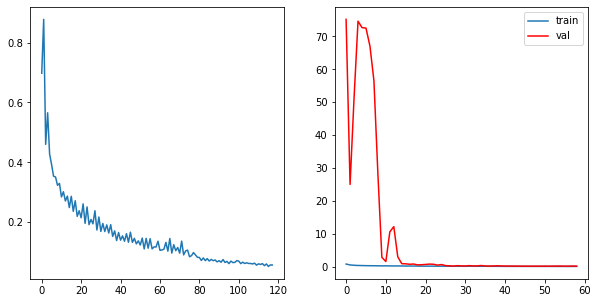

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0600, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0540, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.9492), tensor(0.9534)]
IOU_val:  [tensor(0.8521)]
Epoch 59	 \Training Loss: 0.056968919932842255	     Validation Loss:0.1649426519870758	 \ LR:0.001	 \ IOU_train:0.9513013362884521	     IOU_val:0.8521221876144409


  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0582, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0528, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.9527), tensor(0.9544)]
IOU_val:  [tensor(0.8711)]
Epoch 60	 \Training Loss: 0.055481720715761185	     Validation Loss:0.15512558817863464	 \ LR:0.001	 \ IOU_train:0.9535400867462158	     IOU_val:0.8710653781890869


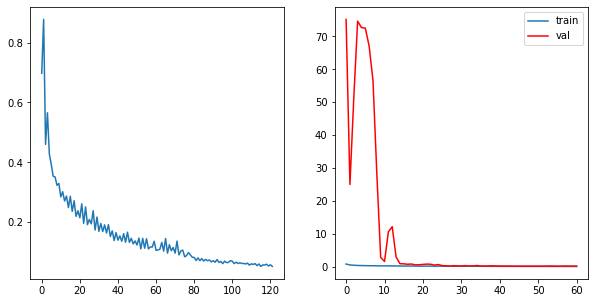

  0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.0573, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0524, grad_fn=<BinaryCrossEntropyBackward0>)


  0%|          | 0/1 [00:00<?, ?it/s]

IOU_train:  [tensor(0.9518), tensor(0.9548)]
IOU_val:  [tensor(0.8639)]
Epoch 61	 \Training Loss: 0.05485713109374046	     Validation Loss:0.16181416809558868	 \ LR:0.001	 \ IOU_train:0.9532794952392578	     IOU_val:0.8639482259750366


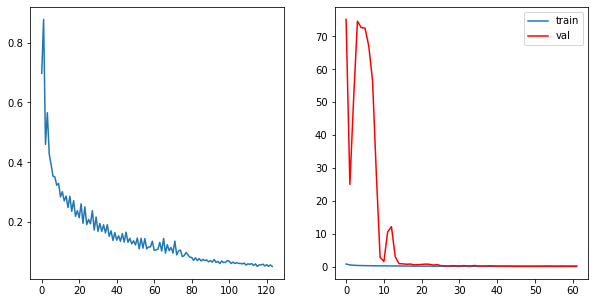

  0%|          | 0/2 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [115]:
from tqdm.notebook import tqdm
step_losses = []
epoch_losses_train = []
epoch_losses_val = []

for epoch in tqdm(range(epochs)):
    epoch_loss = 0
    epoch_loss_test = 0
    jaccard_train = []
    jaccard_val = []
    model.train()
    for X, Y in tqdm(data_loader, total=len(data_loader)):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        step_losses.append(loss.item())
        print(loss)
        jaccard_train.append(jaccard(Y_pred, Y.int()))
        print(jaccard(Y_pred, Y.int()))
    if epoch % 5 == 0:
        state = {'info':  "house aug att"+str(optimizer.param_groups[0]['lr']),            # описание
         'date':      datetime.datetime.now(),   # дата и время
         'model' :    model.state_dict(),        # параметры модели
         'optimizer': optimizer.state_dict()}    # состояние оптимизатора
        torch.save(state, '/house_aug_att_' + str(epoch)+ '.pth')
    with torch.no_grad():
        model.eval()
        for X, Y in tqdm(data_loader_val, total=len(data_loader_val), leave=False):
            X, Y = X.to(device), Y.to(device)
            Y_pred = model(X)
            loss_test = criterion(Y_pred, Y)
            epoch_loss_test += loss_test.item()
            jaccard_val.append(jaccard(Y_pred, Y.int()))
            print(jaccard(Y_pred, Y.int()))
    epoch_losses_val.append(epoch_loss_test/len(data_loader_val))
    epoch_losses_train.append(epoch_loss/len(data_loader))
    scheduler.step(epoch_loss_test/len(data_loader_val))
    curr_lr = optimizer.param_groups[0]['lr']
    print('IOU_train: ', jaccard_train)
    print('IOU_val: ', jaccard_val)
    
  
    print(f'Epoch {epoch}\t \Training Loss: {epoch_loss/len(data_loader)}\t \
    Validation Loss:{epoch_loss_test/len(data_loader_val)}\t \ LR:{curr_lr}\t \ IOU_train:{sum(jaccard_train)/len(data_loader)}\t \
    IOU_val:{sum(jaccard_val)/len(data_loader_val)}')
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].plot(step_losses)
    axes[1].plot(epoch_losses_train, label = 'train')
    axes[1].plot(epoch_losses_val, color = 'red', label = 'val')
    axes[1].legend()
    plt.show()


Тестирование

Берем для теста checkpoint 55 эпохи

In [22]:
state = torch.load('/house_aug_att_55.pth', map_location=torch.device('cpu'))
model = UNet(num_classes=1)
#optimizer = optim.Adam(model.parameters(), lr=0.001)
model.load_state_dict(state['model'])        # получаем параметры модели
#optimizer.load_state_dict(state['optimizer'])    # получаем состояние оптимизатора

print(state['info'], state['date'])
#model.eval()

house aug att0.001 2023-03-11 18:55:55.700254


Тест на валидационной выборке

In [75]:
dataset_val = Dataset_new(df_val)
data_loader_val = DataLoader(dataset_val, batch_size=5)
X, Y = iter(data_loader_val).next()
X, Y = X.to(device), Y.to(device)
print(X.shape, Y.shape)

torch.Size([5, 3, 256, 256]) torch.Size([5, 1, 256, 256])


In [76]:
with torch.no_grad():
    model.eval()
    Y_pred = model(X)
    criterion = nn.BCELoss()
    print(criterion(Y_pred, Y))
    print(jaccard(Y_pred, Y.int()))

tensor(0.0795)
tensor(0.9294)


In [77]:
#model.eval()
#Y_pred = model(X)
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
    ])
fig, axes = plt.subplots(5, 3, figsize=(3*5, 9*5))

for i in range(5):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].permute(1, 2, 0).cpu().detach().numpy()
    label_class_predicted = (Y_pred[i]).permute(1, 2, 0).cpu().detach().numpy()
    
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class, cmap='gray')
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted, cmap='gray')
    axes[i, 2].set_title("Label Class - Predicted")

Тестирование на тестовой выборке

In [20]:
alls_images = os.listdir('/house/test/images')
alls_images_train = []
for i in range(len(alls_images)):
    alls_images_train.append(Path('/house/test/images/'+alls_images[i]))

alls_masks = os.listdir('/house/test/masks')
alls_masks_new = []
for i in range(len(alls_images)):
    for j in range(len(alls_masks)):
        if alls_images[i][0:3] == alls_masks[j][0:3]:
            alls_masks_new.append(alls_masks[j])

alls_masks_train = []
for i in range(len(alls_masks_new)):
    alls_masks_train.append(Path('/house/test/masks/'+alls_masks_new[i]))
    
floor = [17, 17, 6, 5, 14, 17, 10, 14, 17]    


df_test = pd.DataFrame(list(zip(alls_images_train, alls_masks_train, floor)), columns = ['images', 'masks', 'floors'])

In [83]:
state = torch.load('/house_aug_att_55.pth', map_location=torch.device('cpu'))
model = UNet(num_classes=1)
#optimizer = optim.Adam(model.parameters(), lr=0.001)
model.load_state_dict(state['model'])        # получаем параметры модели
#optimizer.load_state_dict(state['optimizer'])    # получаем состояние оптимизатора

print(state['info'], state['date'])
model.eval()

house aug att0.001 2023-03-11 18:55:55.700254


UNet(
  (Relu): ReLU()
  (Sigmoid): Sigmoid()
  (Softmax): Softmax2d()
  (Upsample): Upsample(scale_factor=2.0, mode=nearest)
  (contracting_11): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (contracting_11_res): Sequential(
    (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (contracting_12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (contracting_21): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [78]:
dataset_test = Dataset_new(df_test)
data_loader_test = DataLoader(dataset_test, batch_size=9)
X, Y = iter(data_loader_test).next()
X, Y = X.to(device), Y.to(device)
print(X.shape, Y.shape)

torch.Size([9, 3, 256, 256]) torch.Size([9, 1, 256, 256])


In [79]:
with torch.no_grad():
    model.eval()
    Y_pred = model(X)
    criterion = nn.BCELoss()
    print(criterion(Y_pred, Y))
    print(jaccard(Y_pred, Y.int()))

tensor(0.3014)
tensor(0.7718)


In [80]:
#model.eval()
#Y_pred = model(X)
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
    ])
fig, axes = plt.subplots(9, 3, figsize=(3*5, 9*5))

for i in range(9):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].permute(1, 2, 0).cpu().detach().numpy()
    label_class_predicted = (Y_pred[i]).permute(1, 2, 0).cpu().detach().numpy()
    
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class, cmap='gray')
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted, cmap='gray')
    axes[i, 2].set_title("Label Class - Predicted")

TTA для изображений первоначального размера

In [84]:
t = { #'90_grad' : transforms.RandomRotation((90,90)), 
     #'180_grad' : transforms.RandomRotation((180,180)),
     #'270_grad' : transforms.RandomRotation((270,270)), 
     #'45_grad' : transforms.RandomRotation((45,45)),
     'GaussianBlur' :  transforms.Compose([transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))]),
     'VerticalFlip' : transforms.RandomVerticalFlip(1),
     'HorizontalFlip' : transforms.RandomHorizontalFlip(1)
}
jaccard = JaccardIndex(num_classes = 2).to(device)
mean_jac_test = 0
for i in range(len(df_test)):
    print('Изображение №:', i)
    image_fn = df_test['images'][i]
    image_fp = os.path.join(image_fn)
    image = Image.open(image_fp)
    transform_img_tensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    trans = transforms.Compose([
                transforms.ToTensor()]) 
    image = transform_img_tensor(image)
    shape_1 = image.shape[1]
    shape_2 = image.shape[2]
    if image.shape[1]>image.shape[2]:
        image = transforms.Resize((256, round(256*image.shape[2]/image.shape[1])), Image.NEAREST)(image)
        pad_1 =  (256 - image.shape[2])//2
        pad_2 = round((256 - image.shape[2])/2+0.01)
        x = F.pad(image, ((256 - image.shape[2])//2, round((256 - image.shape[2])/2+0.01)))
    elif image.shape[1]<image.shape[2]:
        image = transforms.Resize((round(256*image.shape[1]/image.shape[2]), 256), Image.NEAREST)(image)
        pad_1 =  (256 - image.shape[1])//2
        pad_2 = round((256 - image.shape[1])/2+0.01)
        x = F.pad(image, (0, 0, (256 - image.shape[1])//2, round((256 - image.shape[1])/2+0.01)))
    else:
        x = transforms.Resize((256, 256), Image.NEAREST)(image)
    
    mask_fn = df_test['masks'][i]
    mask_fp = os.path.join(mask_fn)
    mask = Image.open(mask_fp).convert("L")
    y = trans(mask)

    mean_jac_image = []
    for key in t.keys():
        if key == 'GaussianBlur':
            x_t = t[key](x)
            y_t = y
        else:
            x_t = t[key](x)
            y_t = t[key](y)
        y_pred = model(x_t.reshape(-1, 3, 256, 256))
        y_pred = y_pred.view(1, 256, 256)
        if shape_1>shape_2:
            y_pred = y_pred[:, :, pad_1:256-pad_2]
        elif shape_1<shape_2:
            y_pred = y_pred[:, pad_1:256-pad_2, :]
        y_pred = transforms.Resize((shape_1, shape_2), Image.NEAREST)(y_pred)
        jac_t = jaccard(y_pred, y_t.int())
        print(key, ' : ', jac_t)
        mean_jac_image.append(jac_t)
    y_pred = model(x.reshape(-1, 3, 256, 256))
    
    y_pred = y_pred.view(1, 256, 256)
    if shape_1>shape_2:
        y_pred = y_pred[:, :, pad_1:256-pad_2]
    elif shape_1<shape_2:
         y_pred = y_pred[:, pad_1:256-pad_2, :]
    y_pred = transforms.Resize((shape_1, shape_2), Image.NEAREST)(y_pred)
    jac = jaccard(y_pred, y.int())
   
    print('без преобразований: ', jac)
    mean_jac_image.append(jac)
    print('Лучшее IOU на изображении:', max(mean_jac_image))
    mean_jac_test += max(mean_jac_image)
print('Среднее IOU на всем тестовом датасете:', mean_jac_test/len(df_test))






Изображение №: 0
GaussianBlur  :  tensor(0.5252)
VerticalFlip  :  tensor(0.7810)
HorizontalFlip  :  tensor(0.5660)
без преобразований:  tensor(0.6082)
Лучшее IOU на изображении: tensor(0.7810)
Изображение №: 1
GaussianBlur  :  tensor(0.7807)
VerticalFlip  :  tensor(0.7278)
HorizontalFlip  :  tensor(0.7437)
без преобразований:  tensor(0.8516)
Лучшее IOU на изображении: tensor(0.8516)
Изображение №: 2
GaussianBlur  :  tensor(0.7930)
VerticalFlip  :  tensor(0.7301)
HorizontalFlip  :  tensor(0.7937)
без преобразований:  tensor(0.7930)
Лучшее IOU на изображении: tensor(0.7937)
Изображение №: 3
GaussianBlur  :  tensor(0.7786)
VerticalFlip  :  tensor(0.7691)
HorizontalFlip  :  tensor(0.8051)
без преобразований:  tensor(0.7830)
Лучшее IOU на изображении: tensor(0.8051)
Изображение №: 4
GaussianBlur  :  tensor(0.6127)
VerticalFlip  :  tensor(0.5751)
HorizontalFlip  :  tensor(0.5863)
без преобразований:  tensor(0.6038)
Лучшее IOU на изображении: tensor(0.6127)
Изображение №: 5
GaussianBlur  :  t